# Analysing Reliability of DOSPERT answers of 20 LLMs

- We want to measure, for each LLM, how consistent it is in assigning probabilities across the 40-item answer patterns of a single human. Essentially: “Does the LLM consistently see the human’s answer pattern as more or less probable, or is it erratic?”

In [1]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg
import seaborn as sns

# Loading all data files

# Initialize empty list to store DataFrames
dospert_dataframes = []

path = "outputs"  # folder with CSVs of LLM answers

for file in glob.glob(os.path.join(path, "*_dospert_scores.csv")):
    model_name = os.path.basename(file).replace("_dospert_scores.csv", "")
    
    # Read the CSV
    df = pd.read_csv(file)
    
    # Append to list
    dospert_dataframes.append(df)
    
# Concatenate all DataFrames into one big DataFrame
merged_dospert_data = pd.concat(dospert_dataframes, ignore_index=True)

print(f"Merged DataFrame shape: {merged_dospert_data.shape}")
print(f"Total models: {merged_dospert_data['model'].nunique()}")
#print(f"Models included: {sorted(merged_dospert_data['model'].unique())}")

# add column with predicted logprob for actual human answers
# merged_dospert_data['prob_predicted'] = merged_dospert_data.apply(
#     lambda row: row[str(row['human_number'])], axis=1
# )


# Adding category/subscale logic
# therefore, define mapping dictionary
item_to_category = {
    1: "Social", 10: "Social", 16: "Social", 19: "Social", 23: "Social", 26: "Social", 34: "Social", 35: "Social",
    2: "Recreational", 6: "Recreational", 15: "Recreational", 17: "Recreational", 21: "Recreational", 31: "Recreational", 37: "Recreational", 38: "Recreational",
    3: "Gambling", 11: "Gambling", 22: "Gambling", 33: "Gambling",
    4: "Health", 8: "Health", 27: "Health", 29: "Health", 32: "Health", 36: "Health", 39: "Health", 40: "Health",
    5: "Ethical", 9: "Ethical", 12: "Ethical", 13: "Ethical", 14: "Ethical", 20: "Ethical", 25: "Ethical", 28: "Ethical",
    7: "Investment", 18: "Investment", 24: "Investment", 30: "Investment"
}

# Add a new column "domain"
merged_dospert_data["domain"] = merged_dospert_data["item"].map(item_to_category)

# Check column names
#print(f"\nColumns: {list(merged_dospert_data.columns)}")


Merged DataFrame shape: (1208800, 11)
Total models: 20


In [2]:
# ---- Calc Probability for human answer normalized over answer alternatives ----

logprob_cols = ['1', '2', '3', '4', '5']

# Step 1: Convert log-probs to probabilities
# exponentiate the log probabilities
prob_matrix = np.exp(merged_dospert_data[logprob_cols].values)

# Step 2: Normalize so that each row sums to 1
prob_matrix = prob_matrix / prob_matrix.sum(axis=1, keepdims=True)

# Step 3: Add new columns for each normalized probability
for i, col in enumerate(logprob_cols):
    merged_dospert_data[f'prob_{col}'] = prob_matrix[:, i]

# Step 4: Extract probability of actual human choice
# 'human_number' is 1-indexed; need to subtract 1 for zero-based indexing
merged_dospert_data['prob_predicted'] = prob_matrix[np.arange(len(merged_dospert_data)), merged_dospert_data['human_number'] - 1]


In [3]:
# Compute descriptive stats per model
model_summary = merged_dospert_data.groupby("model")["prob_predicted"].agg(["mean", "std"]).reset_index()
model_summary

model      mean           std
0        Falcon-3-10B-Instruct  0.191618  2.013168e-01
1         Falcon-3-1B-Instruct  0.193112  1.944026e-01
2         Falcon-3-7B-Instruct  0.162903  1.335028e-01
3        Llama-3.1-8B-Instruct  0.238223  2.101712e-01
4        Llama-3.2-1B-Instruct  0.209789  1.920322e-01
5        Llama-3.2-3B-Instruct  0.264113  1.975610e-01
6   Ministral-8B-Instruct-2410  0.241262  1.889905e-01
7     Mistral-7B-Instruct-v0.3  0.200000  1.603171e-17
8           OLMo-2-7B-Instruct  0.148558  8.511079e-02
9                   Qwen3-1.7B  0.228950  2.979900e-01
10                    Qwen3-4B  0.145781  9.455393e-02
11                    Qwen3-8B  0.279629  1.793265e-01
12        SmolLM-1.7B-Instruct  0.183191  7.411880e-02
13       SmolLM2-1.7B-Instruct  0.196565  8.209687e-02
14          Unsloth-Qwen3-1.7B  0.228950  2.979900e-01
15               gemma-2-2b-it  0.248694  1.505416e-01
16               gemma-2-9b-it  0.280801  1.438349e-01
17               gemma-3-1b-it  0.213723  1.145620e-01
18               gemma-3-4b-it  0.242222  1.981793e-01
19              zephyr-7b-beta  0.200000  2.185179e-17

In [4]:
# Compute descriptive stats per participant within model
participant_summary = merged_dospert_data.groupby(["model", "participant"])["prob_predicted"].agg(["mean", "std"]).reset_index()
participant_summary.head(20)

model  participant      mean       std
0   Falcon-3-10B-Instruct     64000401  0.174102  0.160684
1   Falcon-3-10B-Instruct     64004701  0.104222  0.086978
2   Falcon-3-10B-Instruct     64006401  0.148252  0.110598
3   Falcon-3-10B-Instruct     64006901  0.089578  0.090762
4   Falcon-3-10B-Instruct     64007901  0.211267  0.214343
5   Falcon-3-10B-Instruct     64008701  0.094015  0.070317
6   Falcon-3-10B-Instruct     64011501  0.182527  0.148416
7   Falcon-3-10B-Instruct     64015601  0.128480  0.098110
8   Falcon-3-10B-Instruct     64016901  0.116649  0.105805
9   Falcon-3-10B-Instruct     64018301  0.348577  0.238972
10  Falcon-3-10B-Instruct     64020401  0.133499  0.131516
11  Falcon-3-10B-Instruct     64020501  0.131080  0.120433
12  Falcon-3-10B-Instruct     64021901  0.147947  0.150926
13  Falcon-3-10B-Instruct     64022901  0.112254  0.117621
14  Falcon-3-10B-Instruct     64025601  0.139794  0.137557
15  Falcon-3-10B-Instruct     64026901  0.469844  0.281953
16  Falcon-3-10B-Instruct     64027801  0.258995  0.200435
17  Falcon-3-10B-Instruct     64029901  0.102130  0.082573
18  Falcon-3-10B-Instruct     64031301  0.103375  0.096176
19  Falcon-3-10B-Instruct     64034901  0.190511  0.156114

In [5]:
# To better understand low variance in some models, check how many unique values there are:
merged_dospert_data[merged_dospert_data['model']=="zephyr-7b-beta"] # simply all probabilities equally likely, no variance!
merged_dospert_data[merged_dospert_data['model']=="Mistral-7B-Instruct-v0.3"] # simply all probabilities equally likely, no variance!
#merged_dospert_data.groupby("model")["prob_predicted"].nunique()
merged_dospert_data[merged_dospert_data['model']=="Mistral-7B-Instruct-v0.3"]["prob_predicted"].round(3).value_counts()
merged_dospert_data[merged_dospert_data['model']=="zephyr-7b-beta"]["prob_predicted"].round(3).value_counts()

prob_predicted
0.2    60440
Name: count, dtype: int64

In [6]:
# Models to exclude?! - I exclude them for now, even though I do not yet understand why they show only identical logprobs per person
exclude_models = ["Mistral-7B-Instruct-v0.3", "zephyr-7b-beta"]
merged_dospert_data = merged_dospert_data[~merged_dospert_data["model"].isin(exclude_models)]

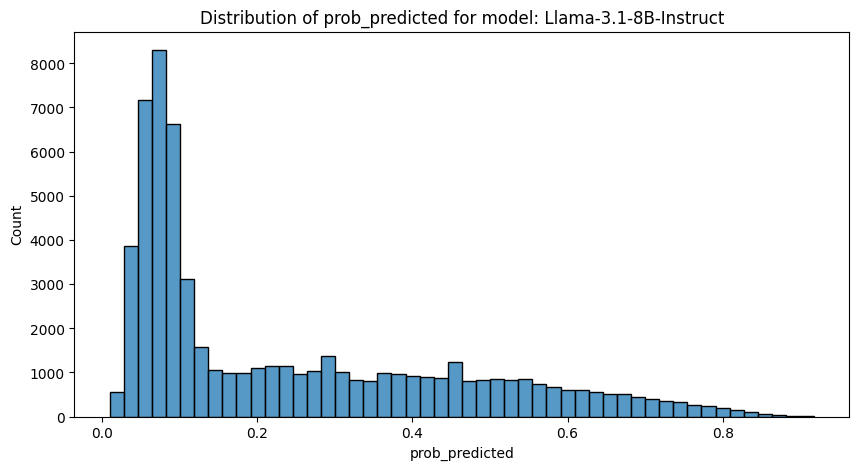

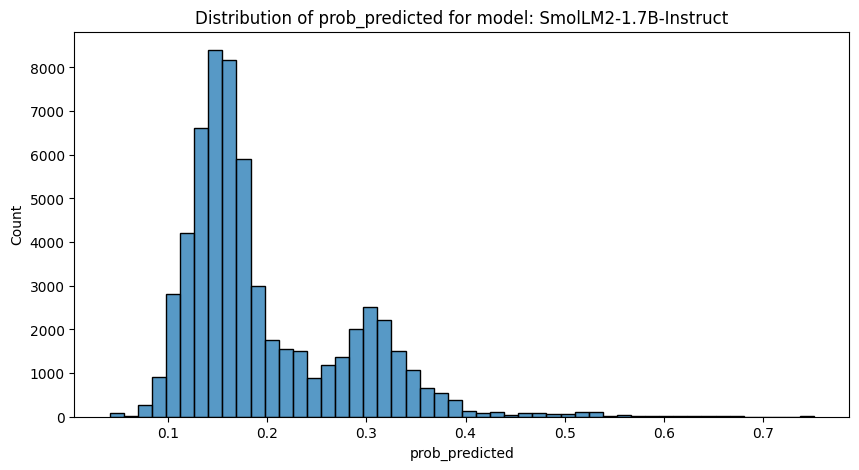

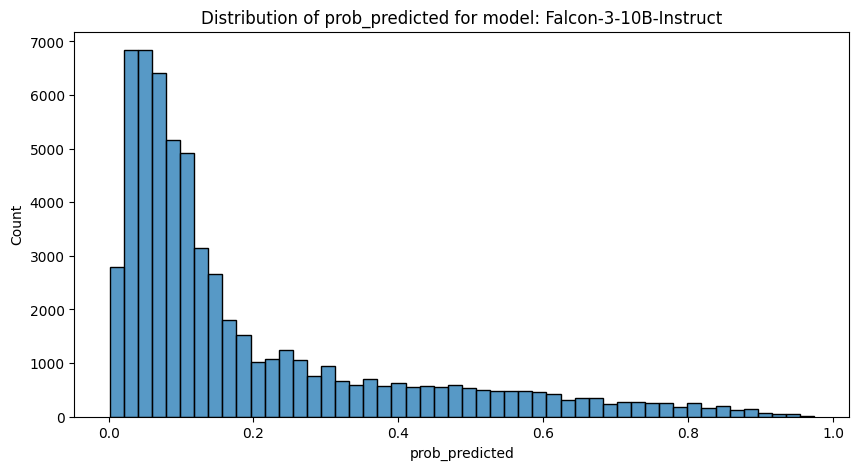

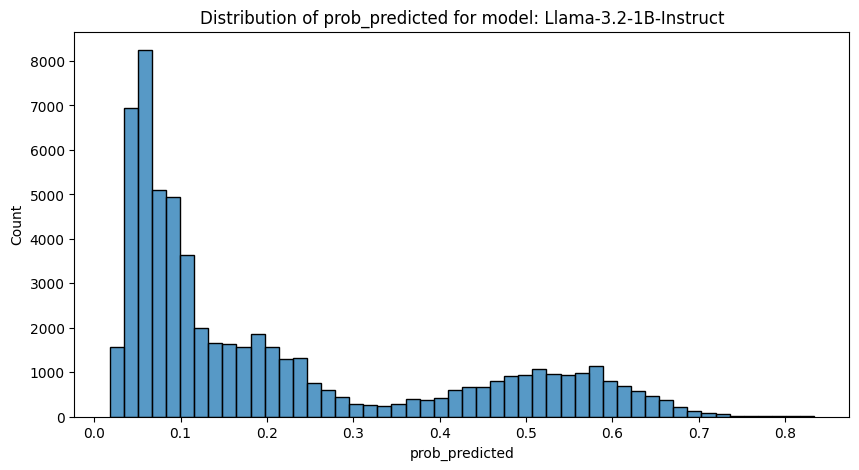

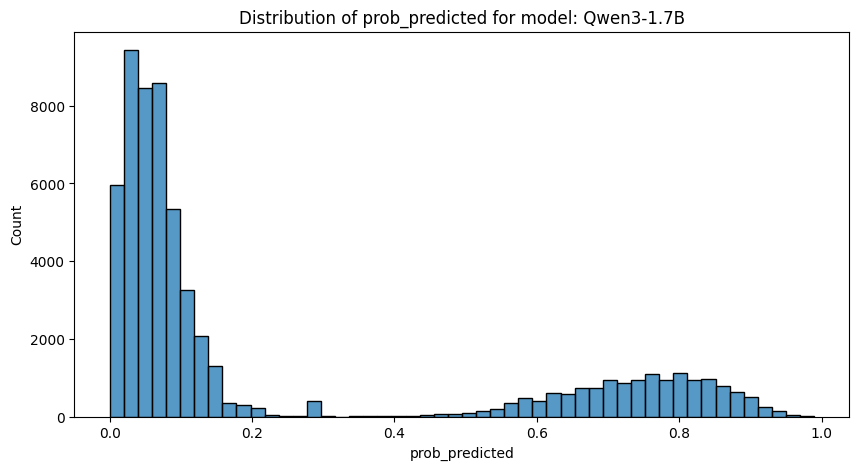

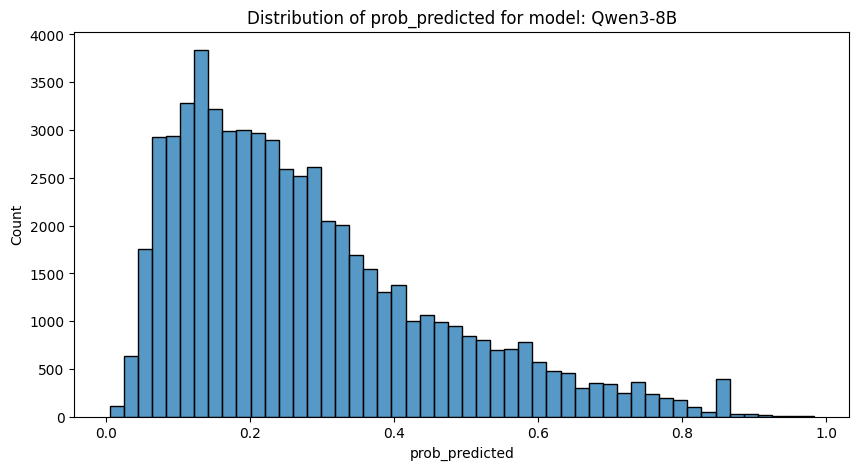

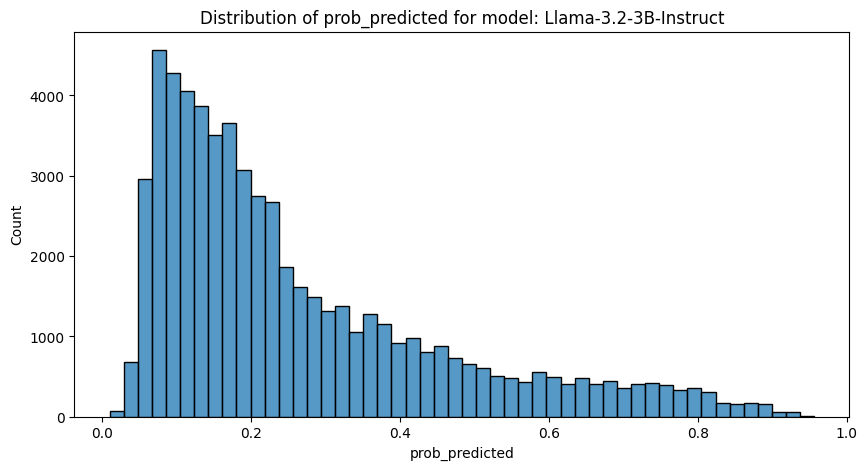

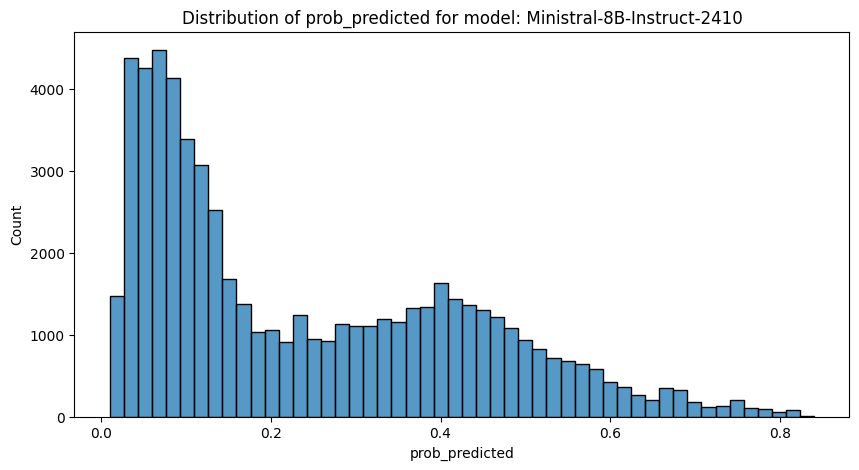

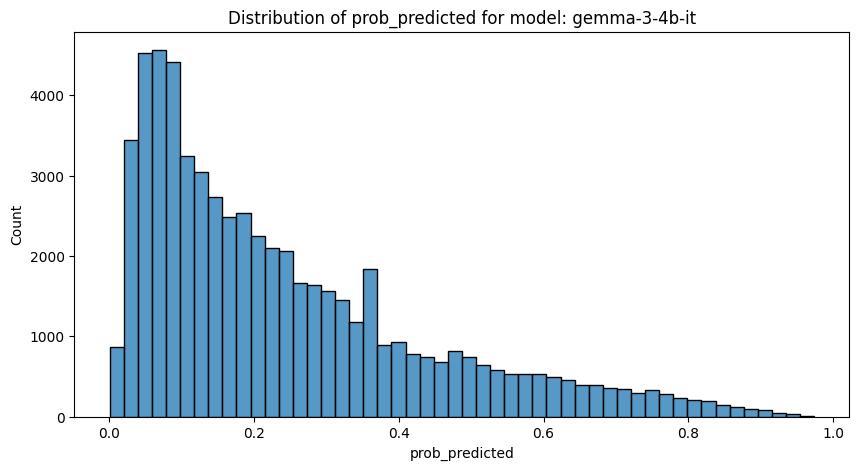

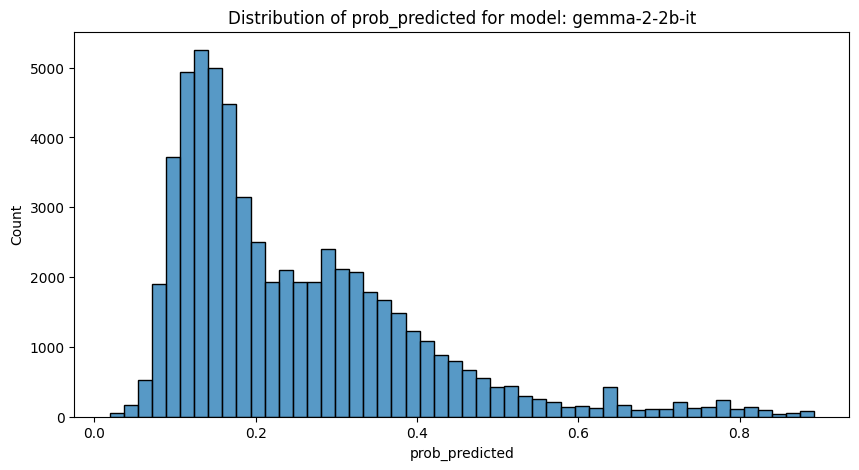

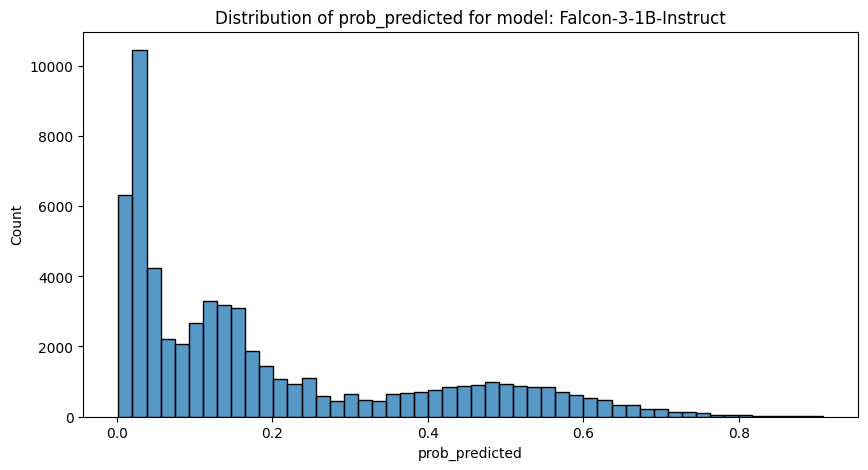

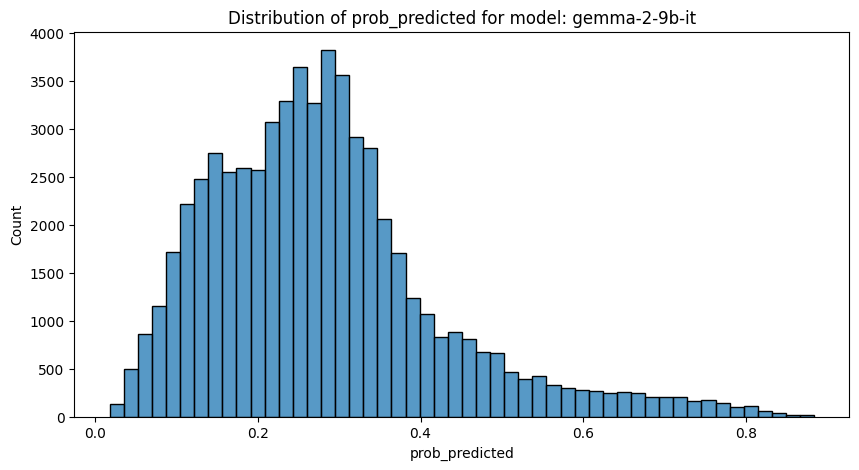

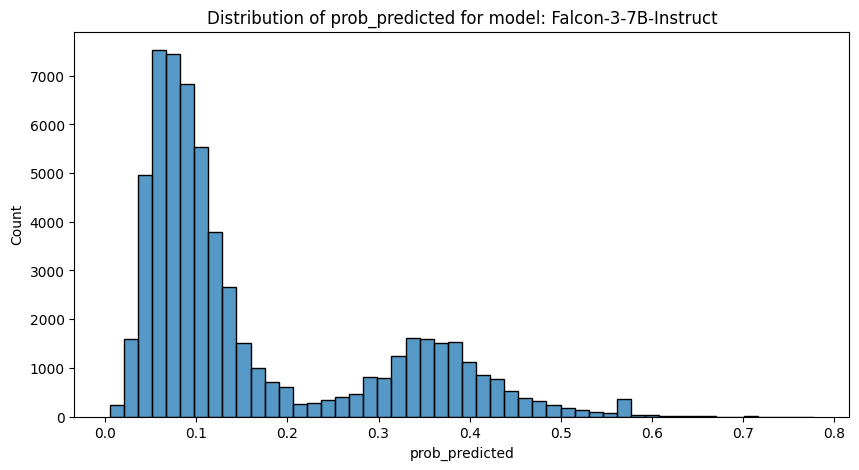

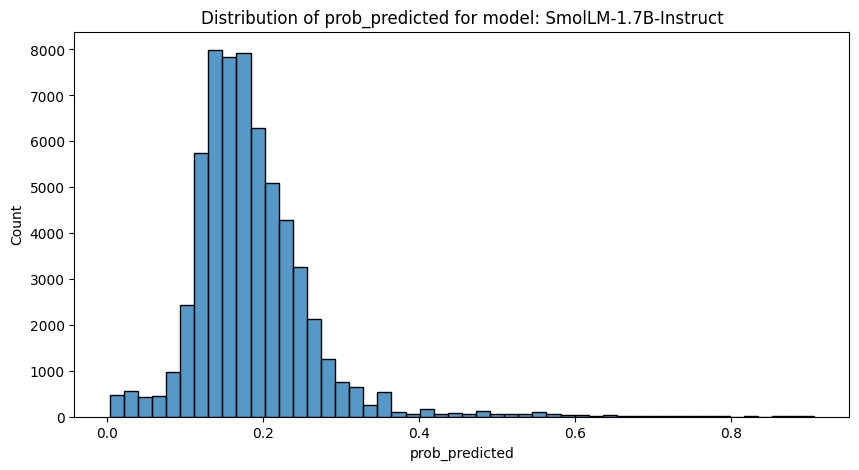

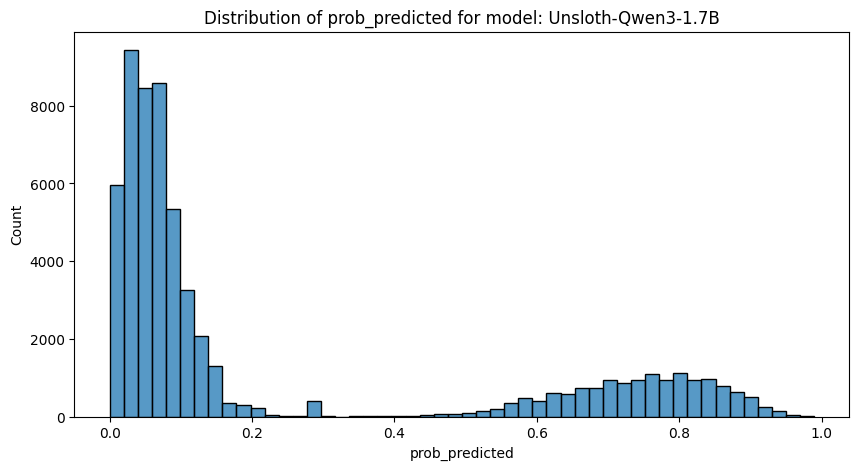

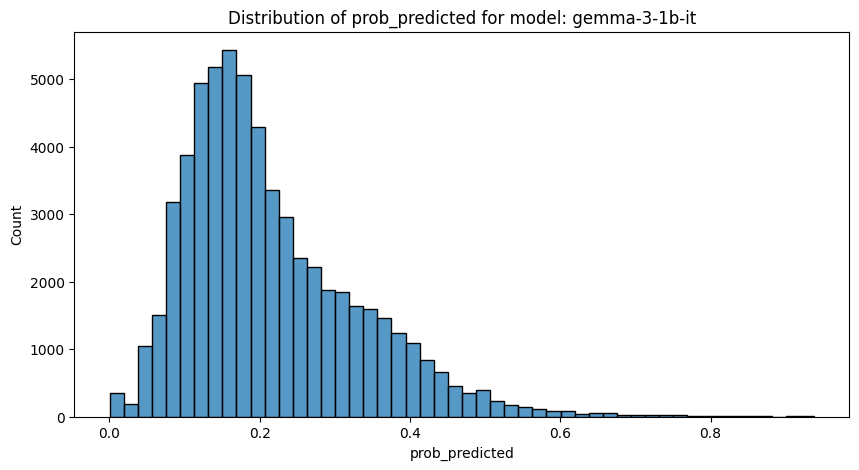

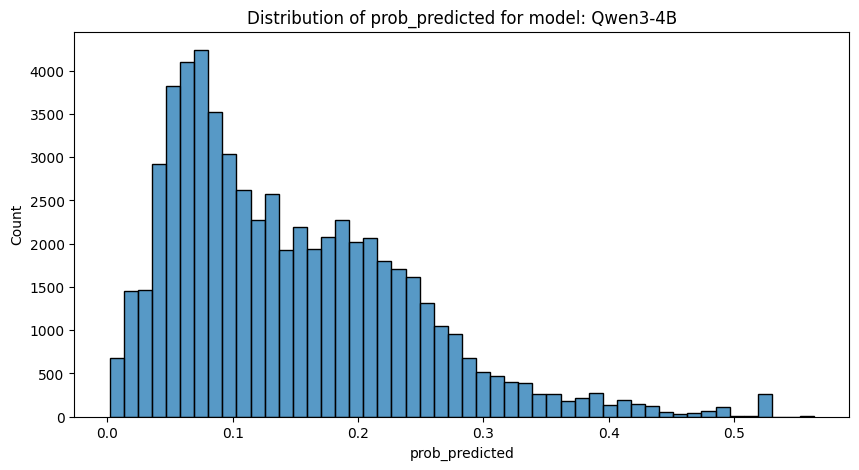

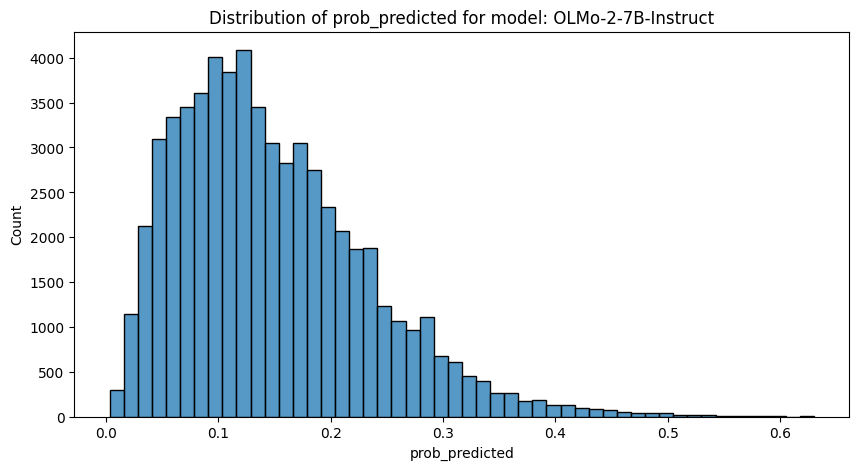

In [7]:
# Visualise distribution (focus on variance) per model of logprobs

model_names = merged_dospert_data['model'].unique()

for model_name in model_names:
    df_plot = merged_dospert_data[merged_dospert_data['model'] == model_name]
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_plot, x="prob_predicted", bins=50)  # KDE optional , kde=True
    plt.title(f'Distribution of prob_predicted for model: {model_name}')
    plt.xlabel('prob_predicted')
    plt.ylabel('Count')
    plt.show()

In [8]:
# ---- Cronbach's alpha per domain ----

# dictionary to store results
results = []

# loop through domains
for domain, domain_data in merged_dospert_data.groupby("domain"):
    
    # loop through models within this domain
    for model, model_data in domain_data.groupby("model"):
        
        # pivot wide format for Cronbach's alpha
        df_wide_domains = model_data.pivot_table(
            index="participant",
            columns="item",
            values="prob_predicted"
        )
        #print(df_wide_domains)
        
        # calculate Cronbach's alpha
        if df_wide_domains.shape[1] > 1:  # need at least 2 items
            alpha, ci = pg.cronbach_alpha(df_wide_domains)
        else:
            alpha, ci = None, (None, None)  # not enough items to compute
        
        # store results
        results.append({
            "domain": domain,
            "model": model,
            "alpha": alpha,
            "alpha_CI": ci
        })

# convert to DataFrame
alpha_df = pd.DataFrame(results)
alpha_df


alphas_wide = alpha_df.pivot_table(
    index=['model'],
    columns='domain',
    values='alpha'
).reset_index()
alphas_wide.set_index("model", inplace=True)

#alphas_wide


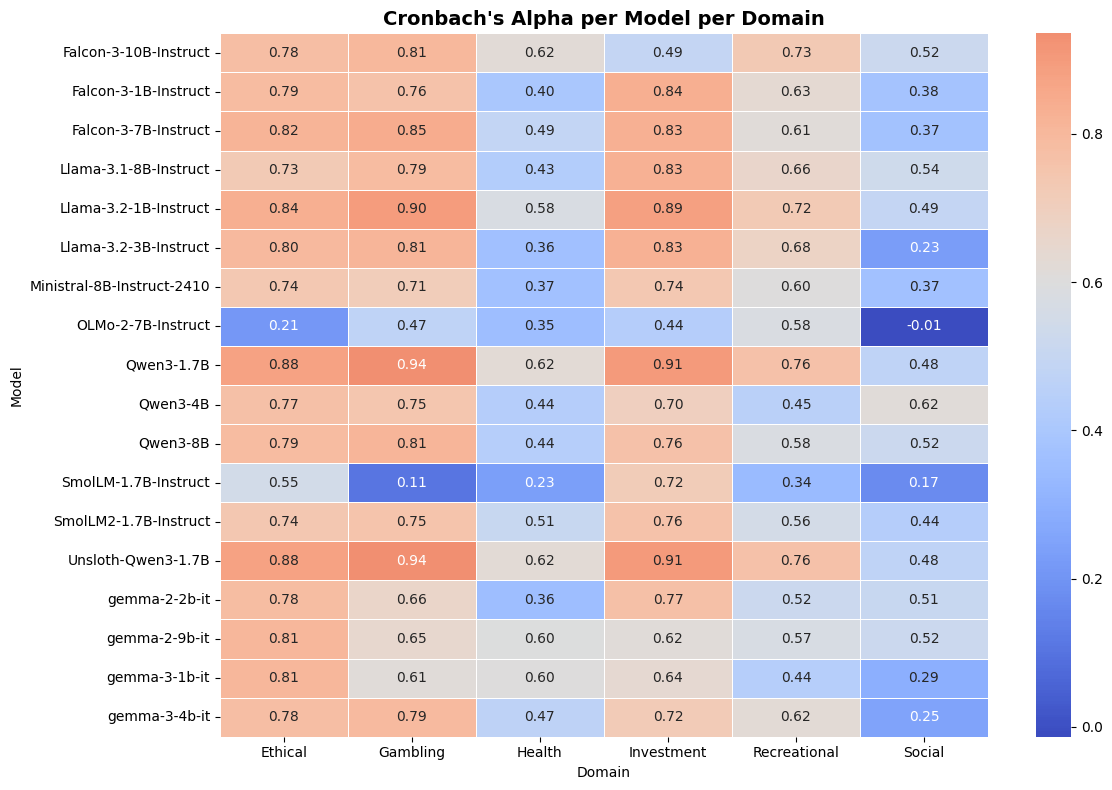

In [9]:
# Visualize Chronbach's Alpha for each model and category
plt.figure(figsize=(12, 8))
sns.heatmap(alphas_wide, annot=True, cmap="coolwarm", center=0.6, fmt=".2f", linewidths=.5)
plt.title("Cronbach's Alpha per Model per Domain", fontsize=14, weight="bold")
plt.xlabel("Domain")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

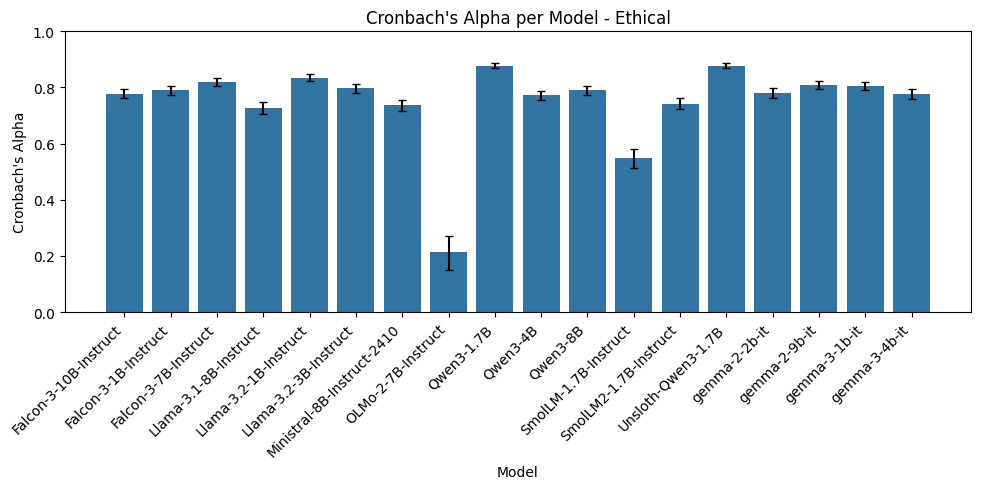

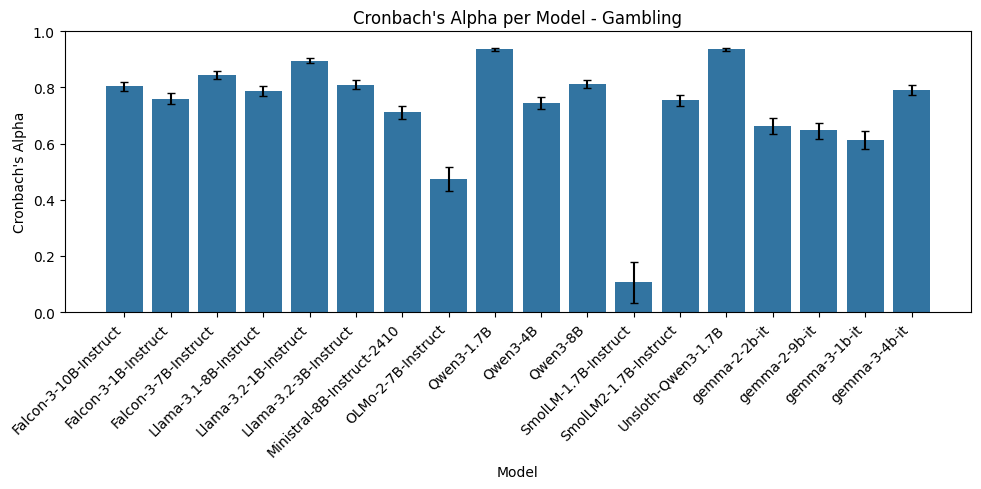

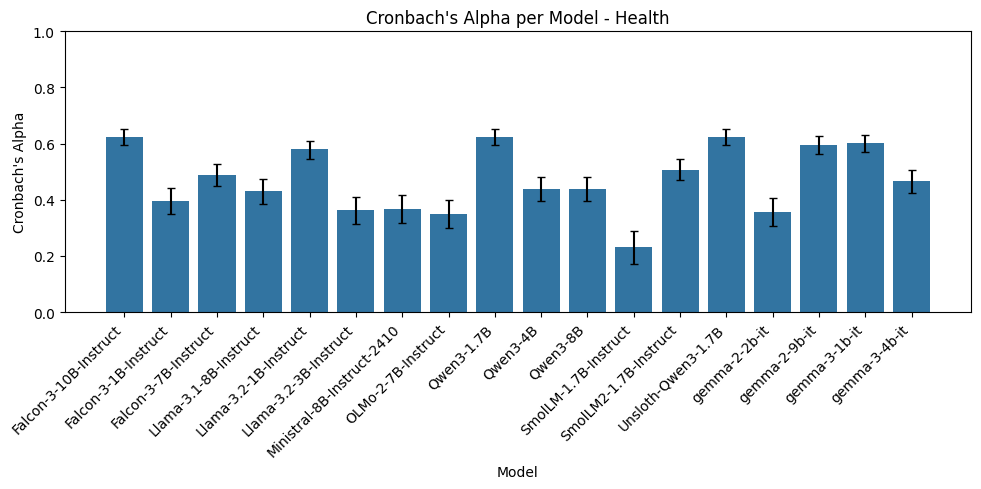

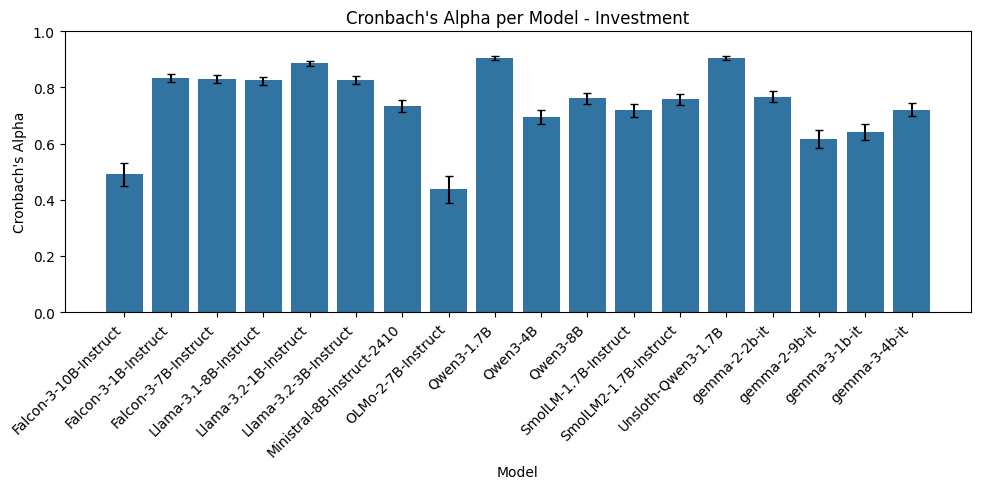

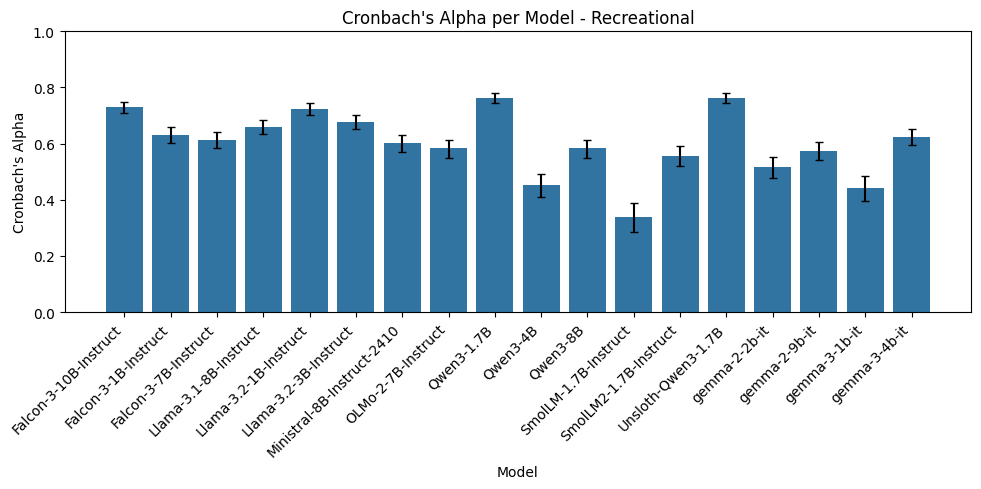

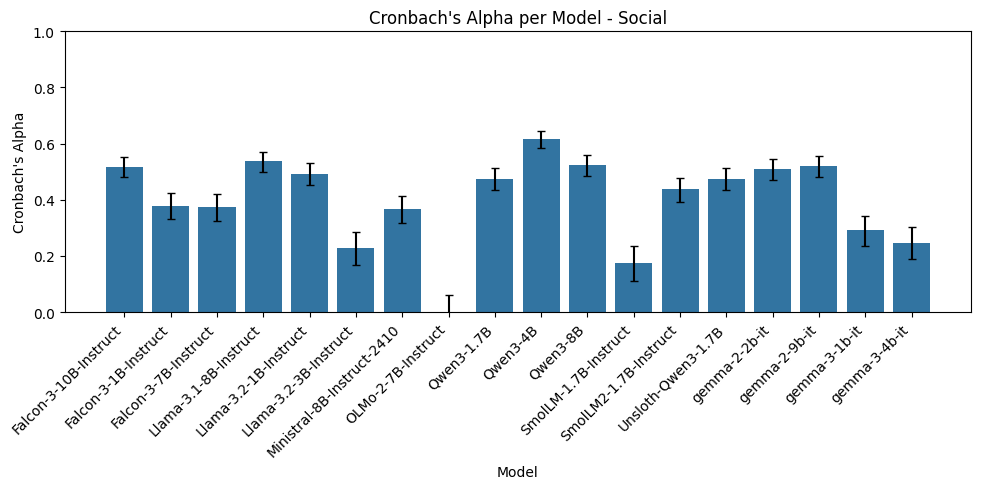

In [10]:
# loop through each domain and plot alphas per model
domains = alpha_df['domain'].unique()

for domain in domains:
    df_plot = alpha_df[alpha_df['domain'] == domain]
    
    plt.figure(figsize=(10,5))
    sns.barplot(data=df_plot, x='model', y='alpha')
    
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)  # Cronbach's alpha range
    plt.title(f"Cronbach's Alpha per Model - {domain}")
    plt.ylabel("Cronbach's Alpha")
    plt.xlabel("Model")
    
    
    # optionally, add CI as error bars if available
    if 'alpha_CI' in df_plot.columns:
        for i, row in df_plot.iterrows():
            ci_low, ci_high =  row['alpha_CI']
            #print(ci_low, ci_high)
            plt.errorbar(
                x=i - df_plot.index.min(),  # bar position
                y=row['alpha'],
                yerr=[[row['alpha'] - ci_low], [ci_high - row['alpha']]],
                fmt='none',
                c='black',
                capsize=3
            )
    
    plt.tight_layout()
    plt.show()


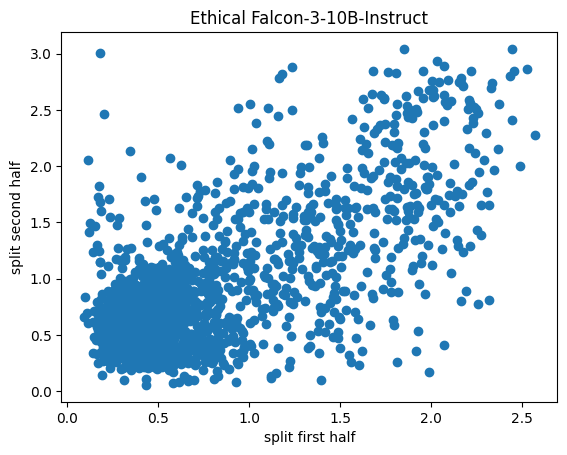

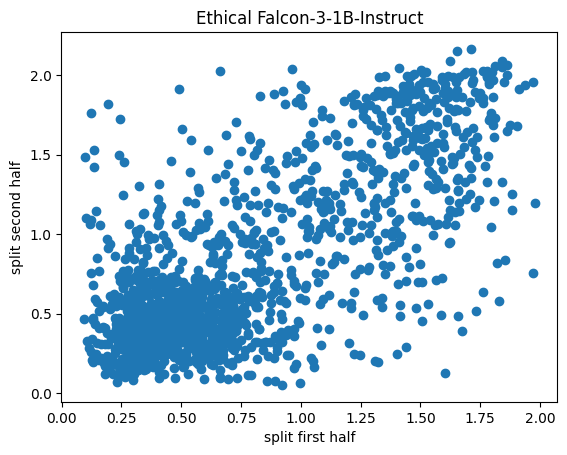

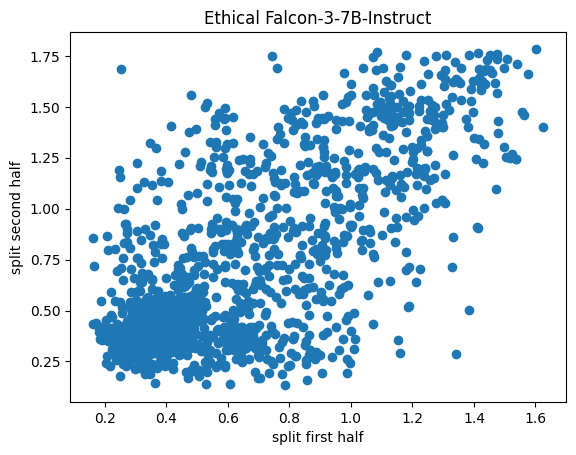

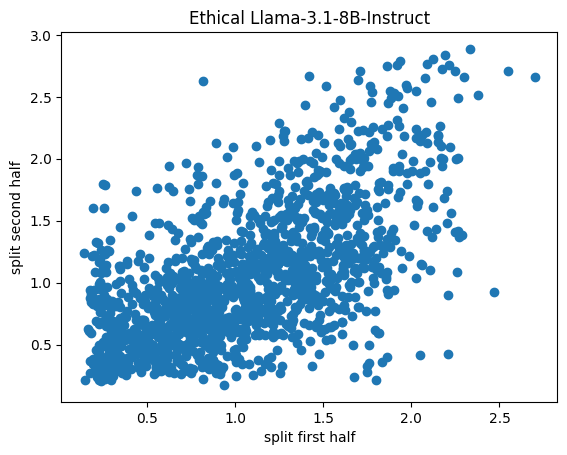

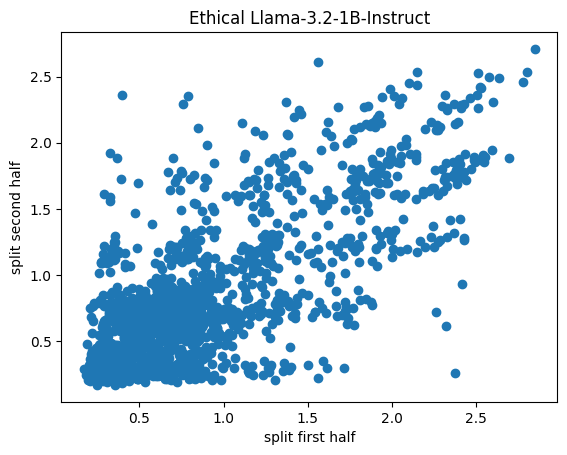

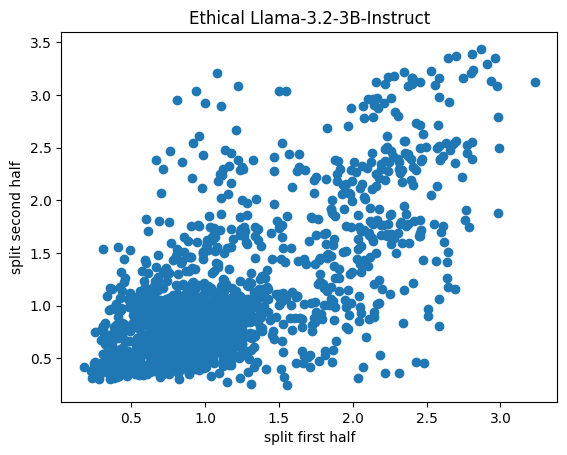

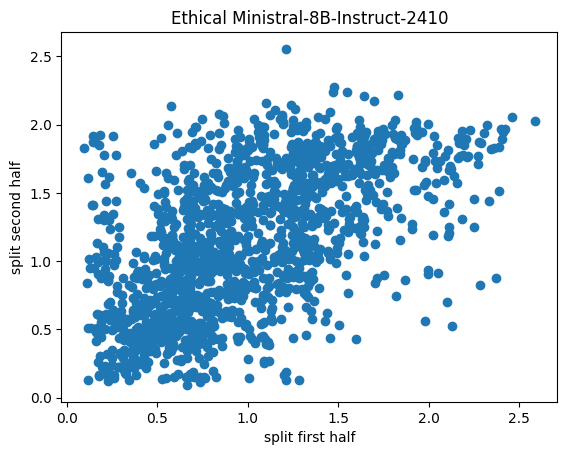

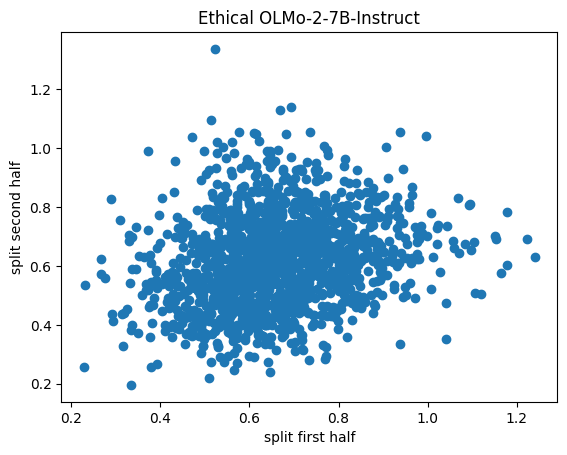

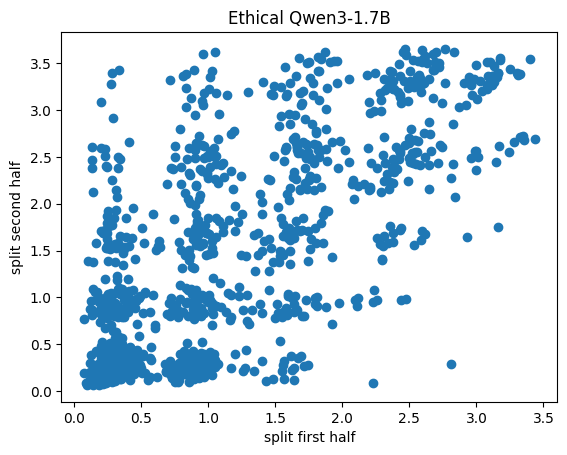

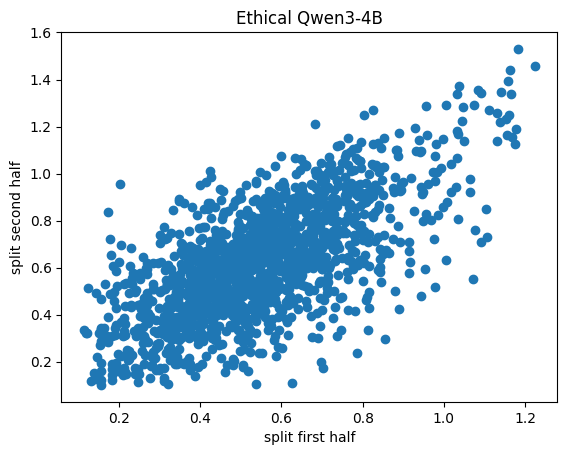

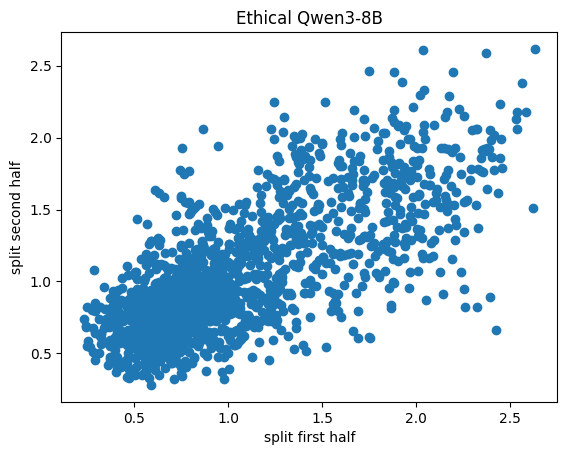

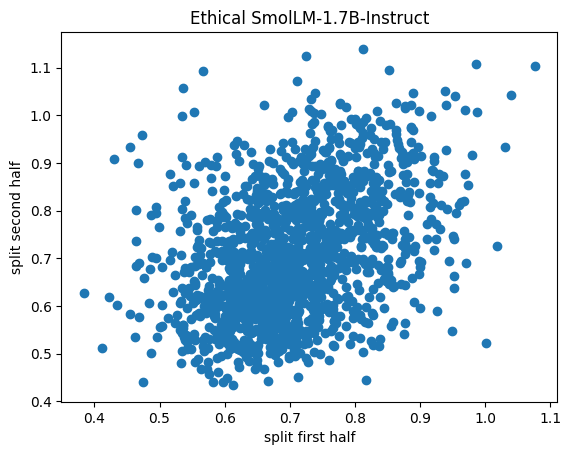

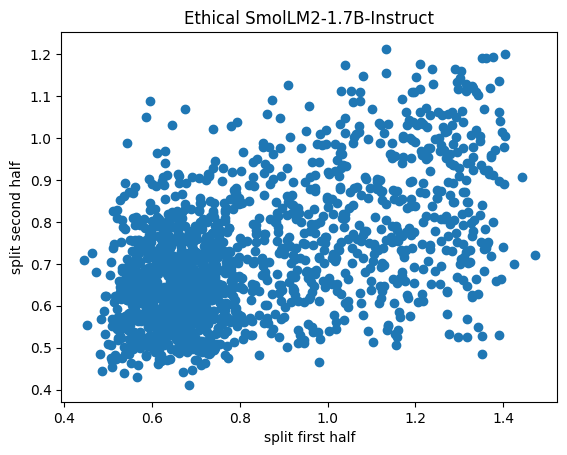

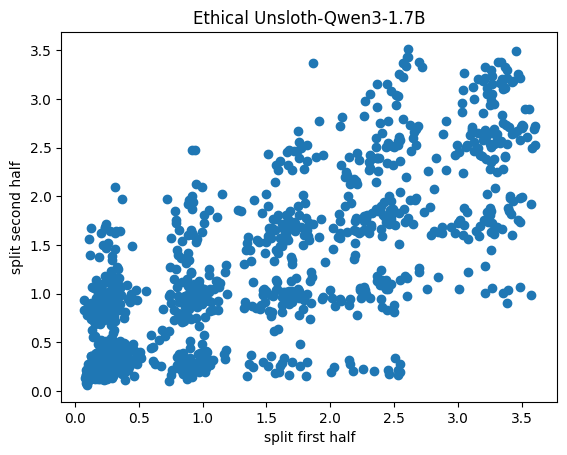

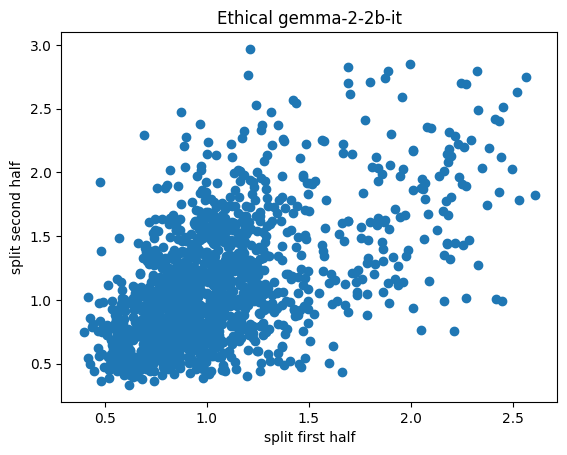

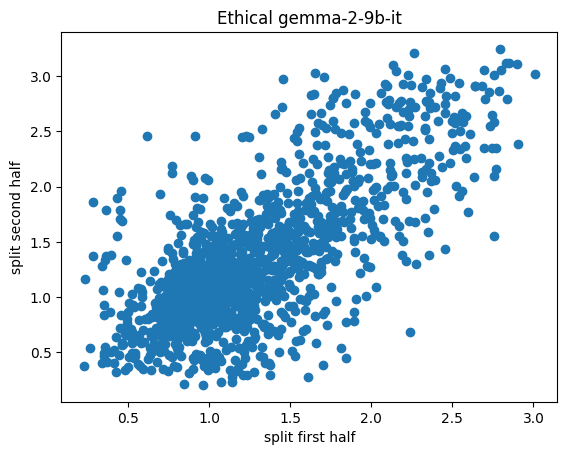

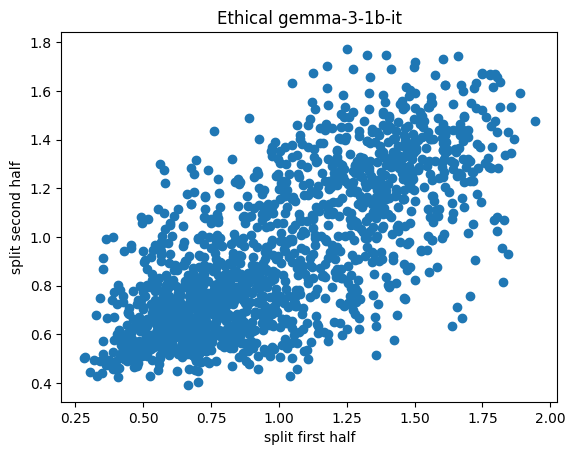

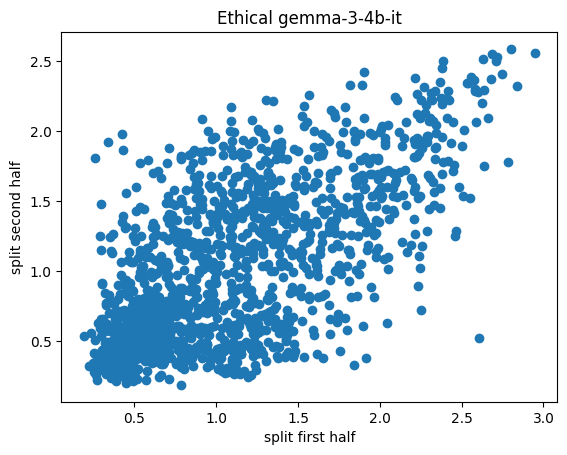

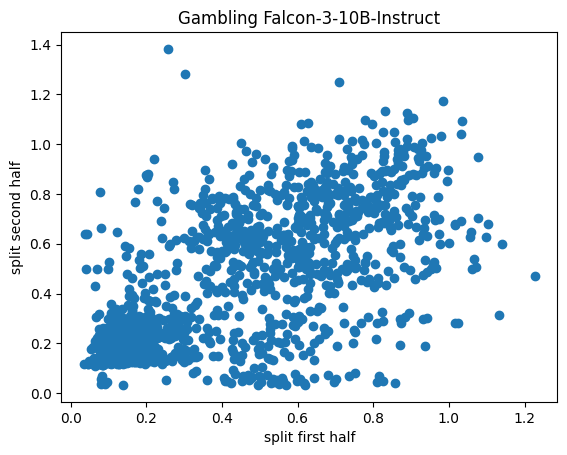

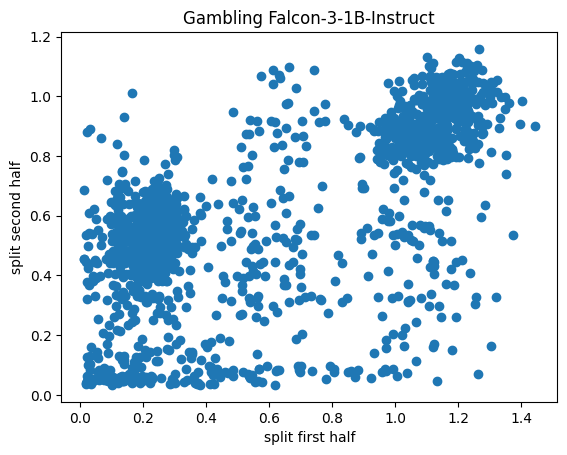

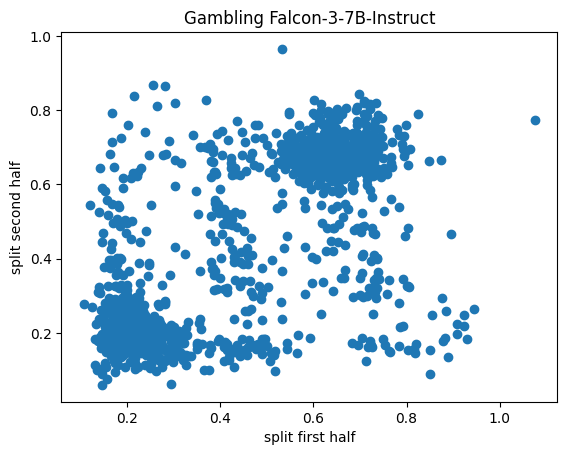

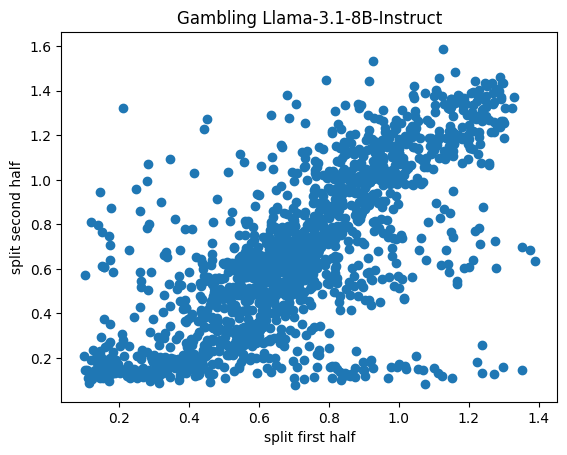

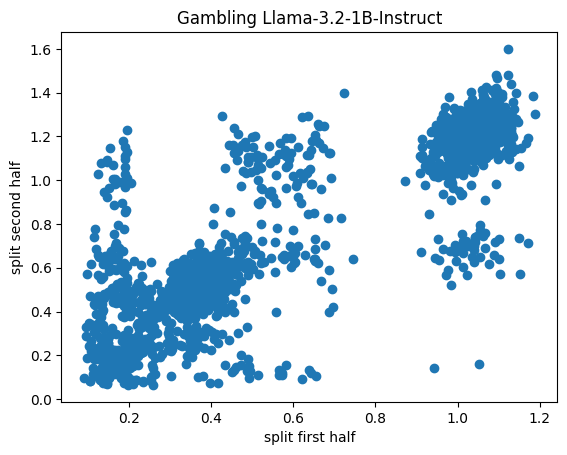

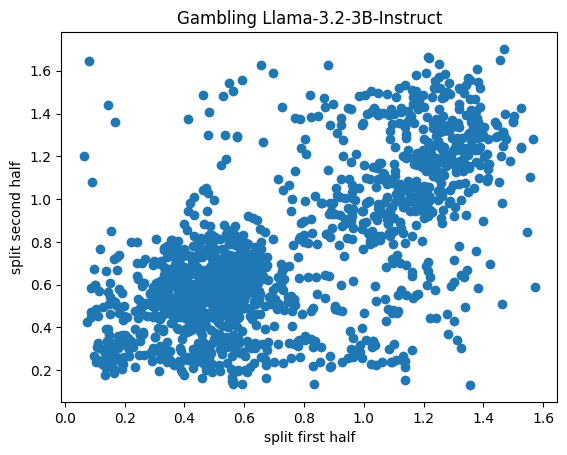

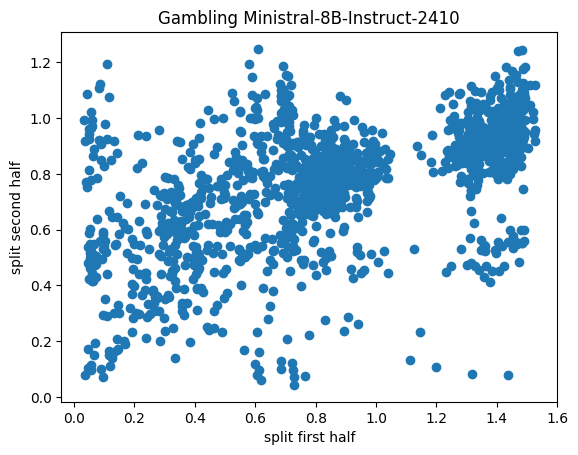

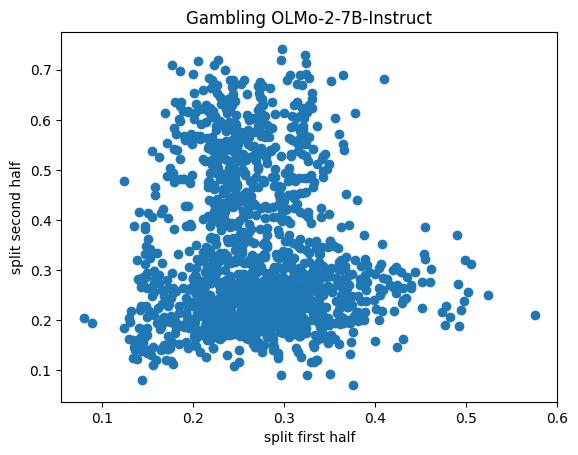

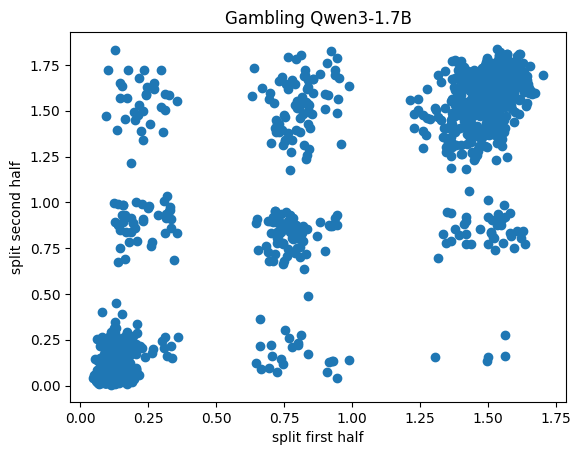

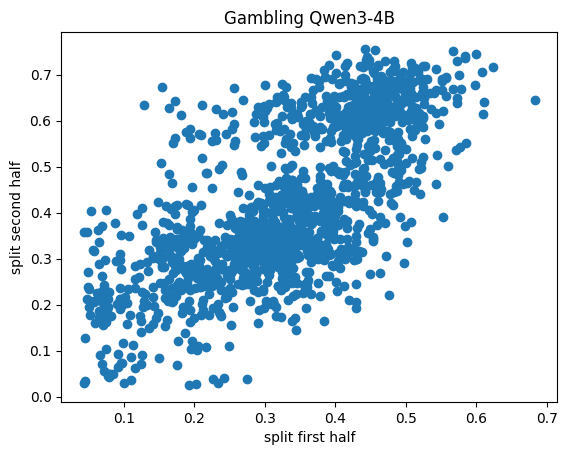

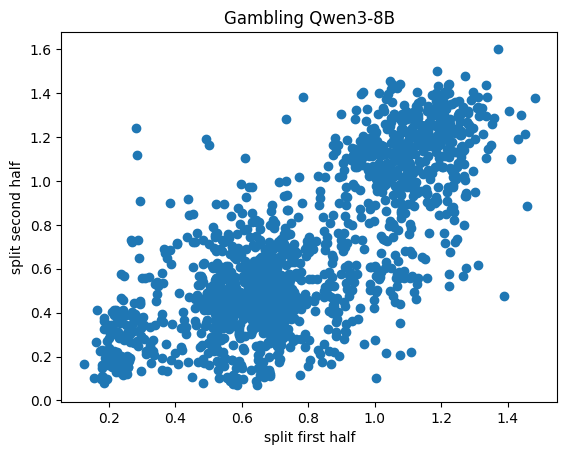

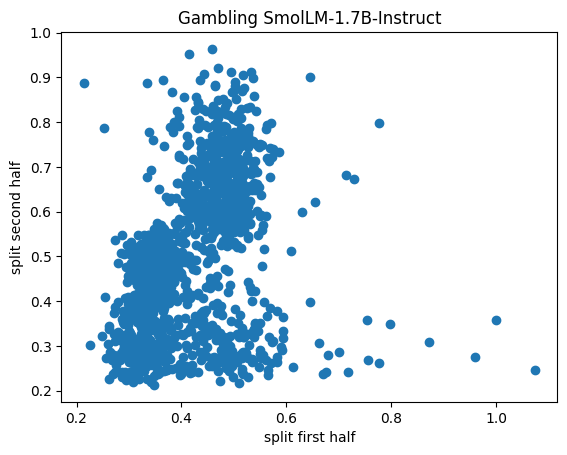

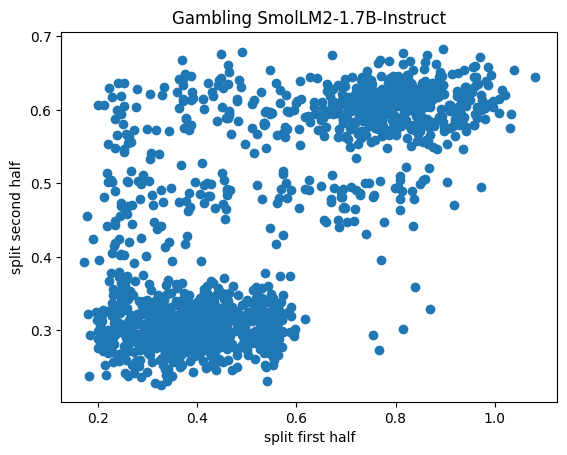

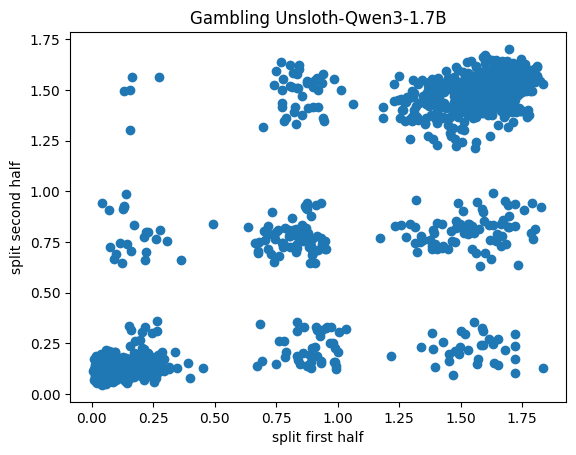

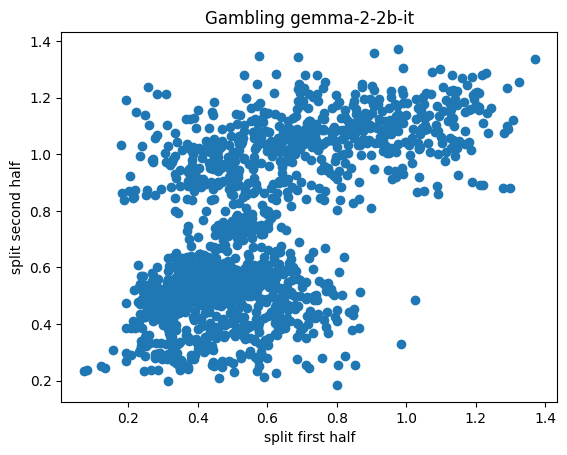

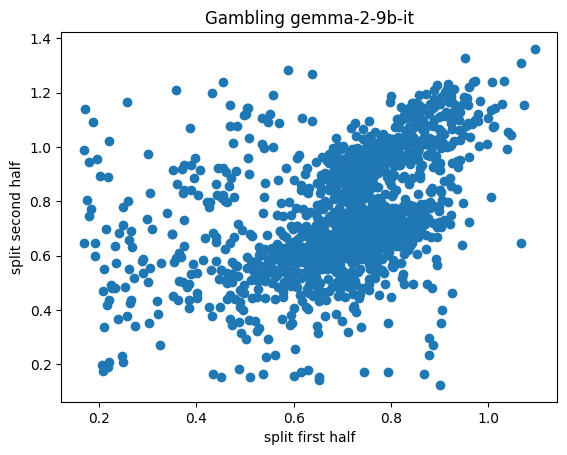

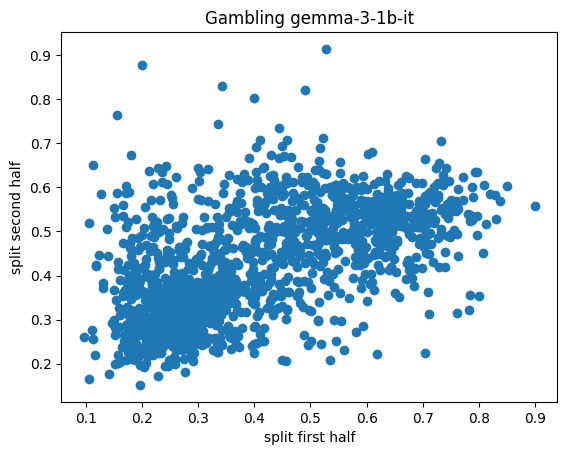

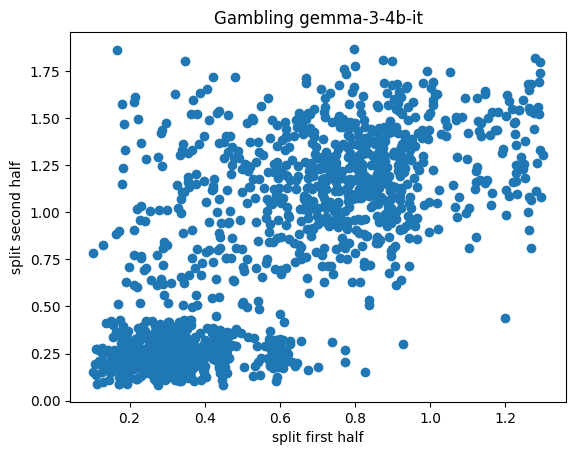

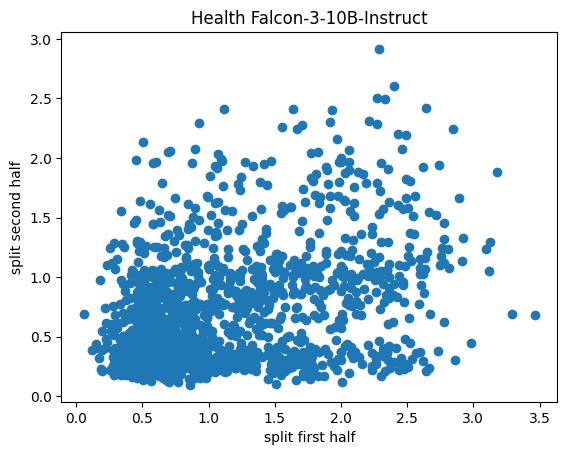

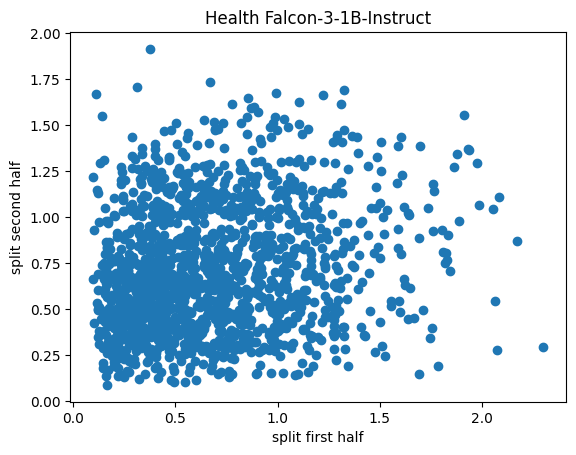

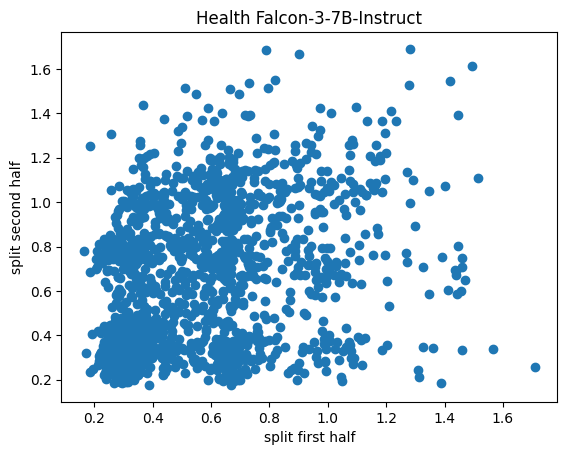

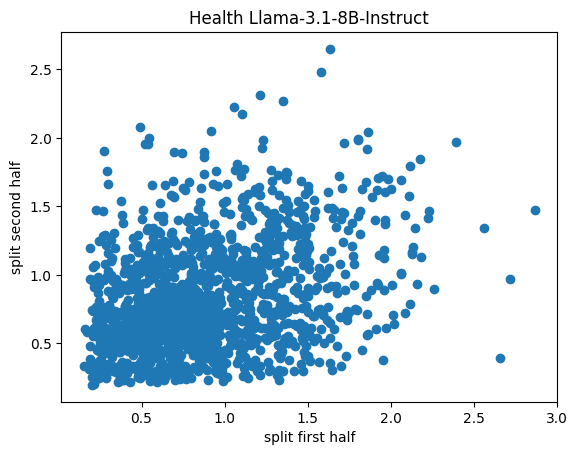

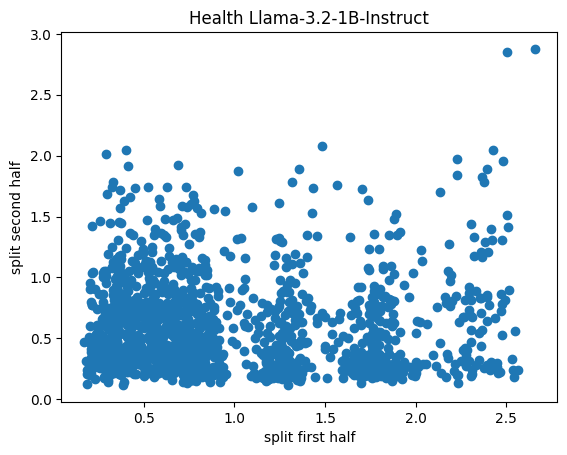

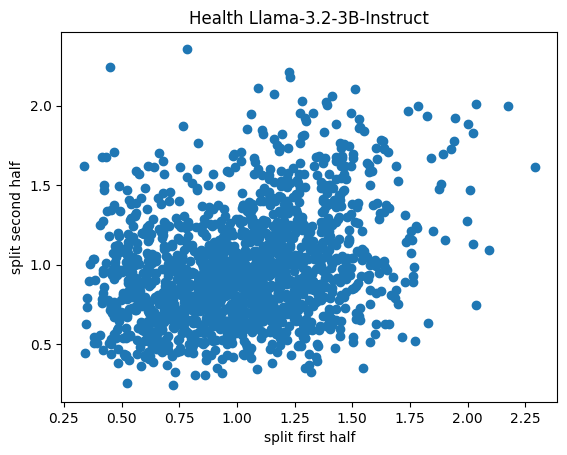

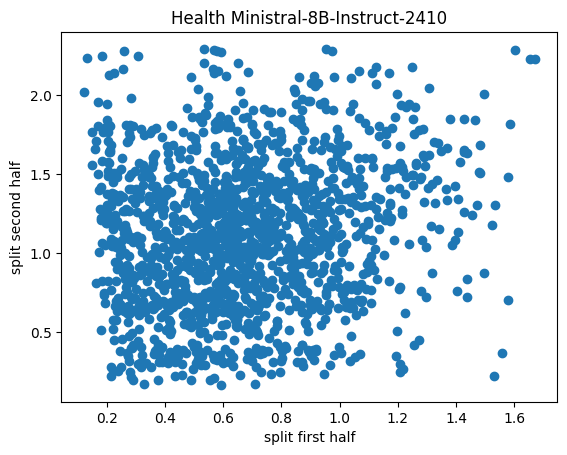

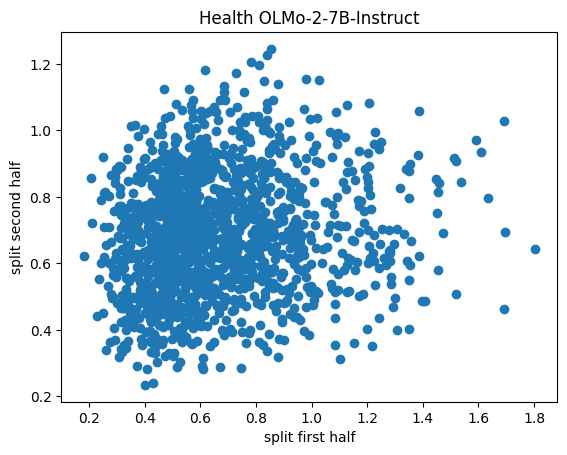

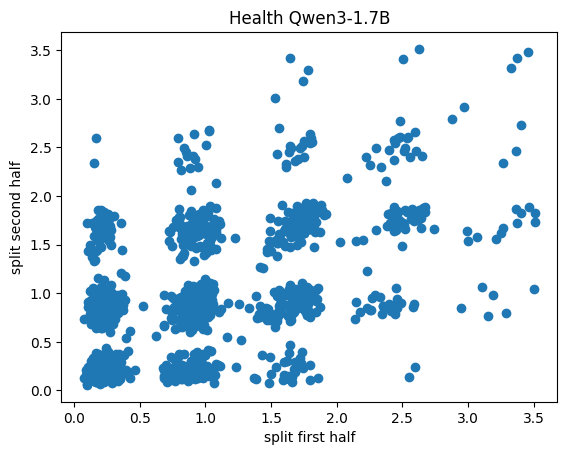

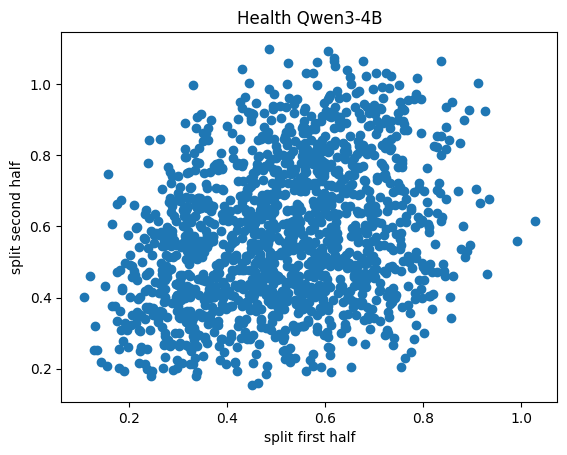

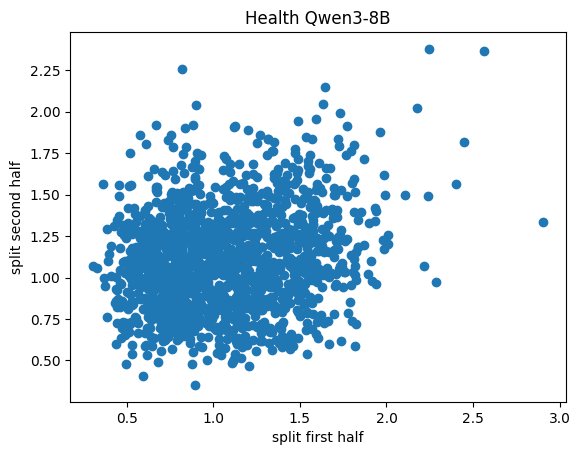

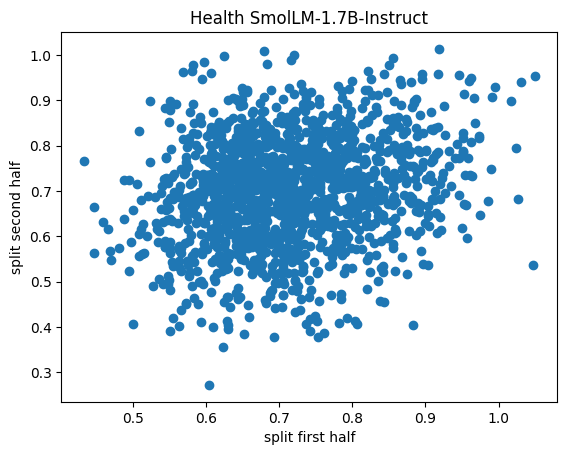

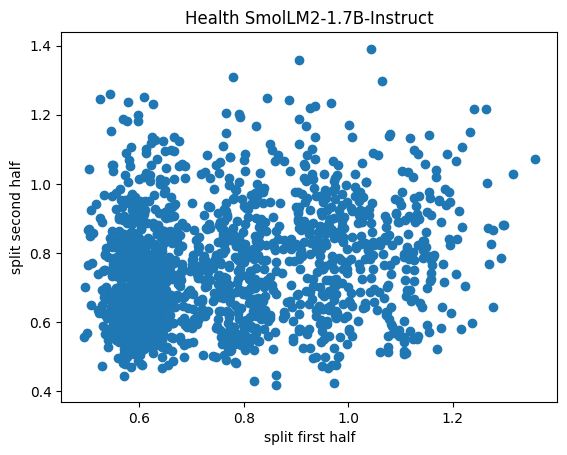

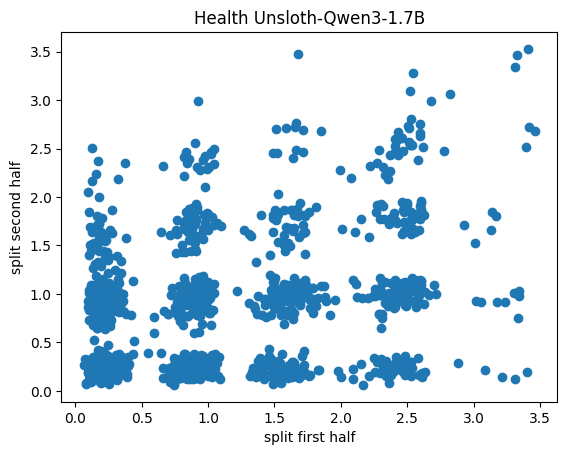

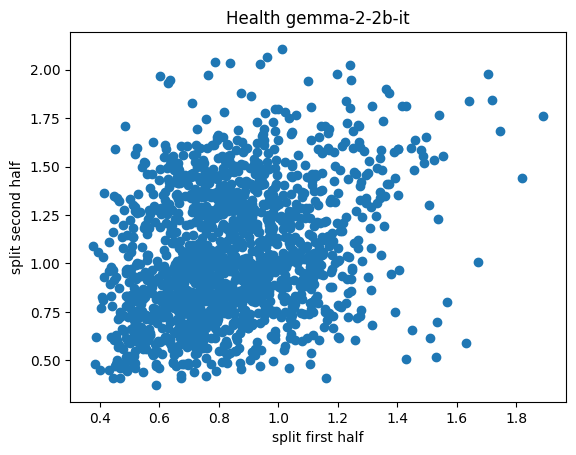

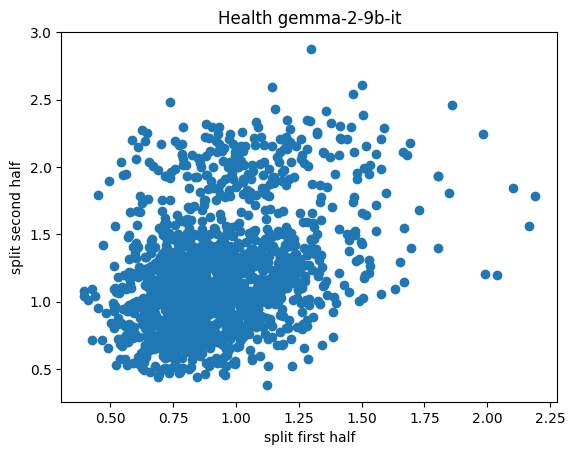

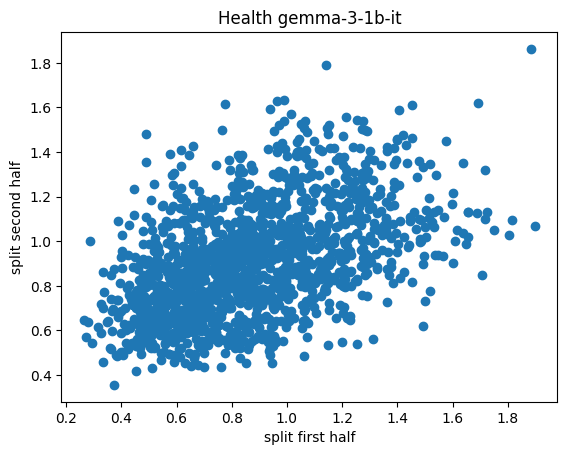

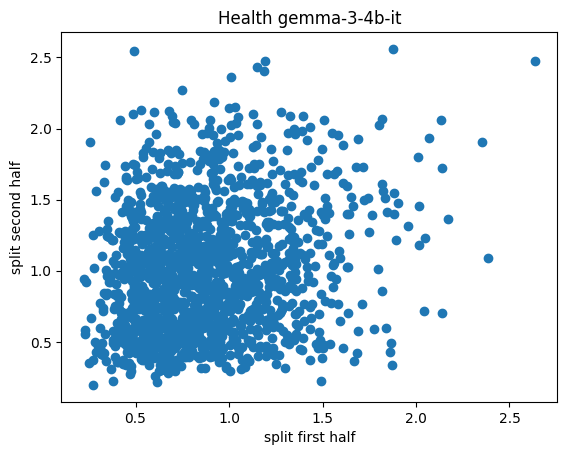

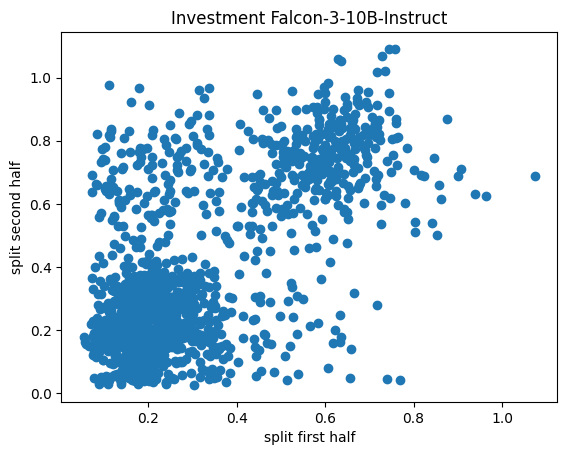

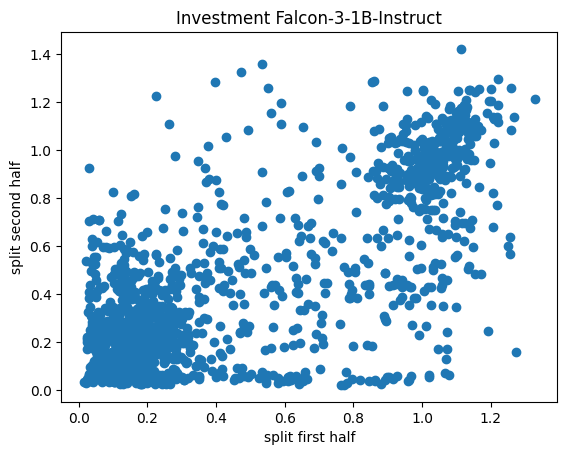

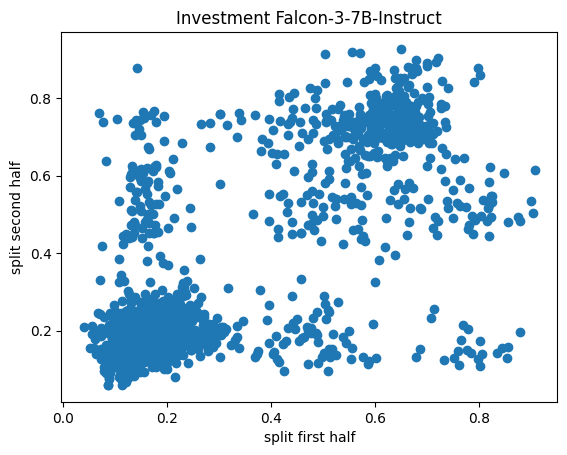

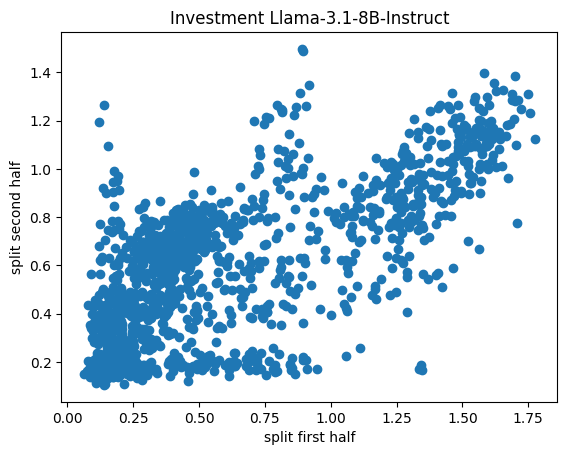

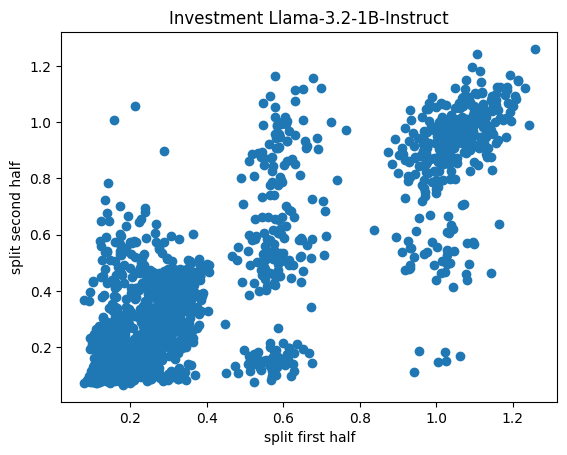

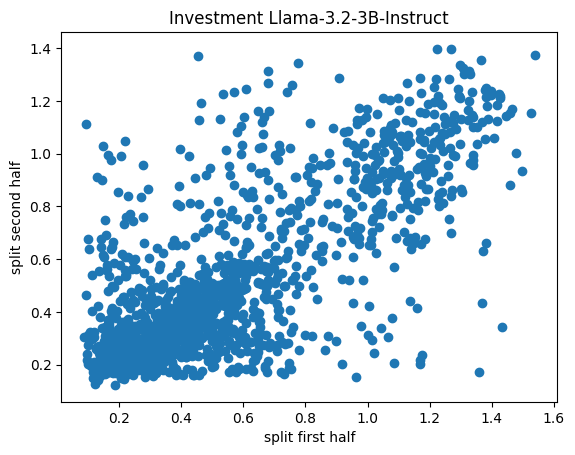

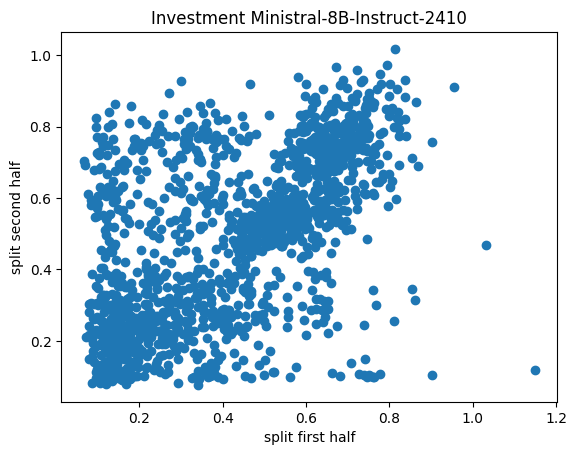

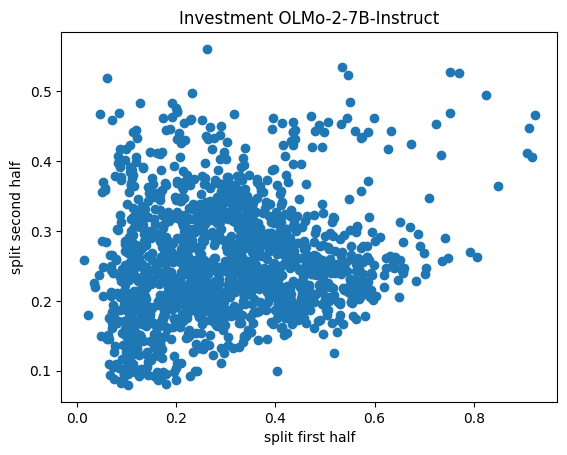

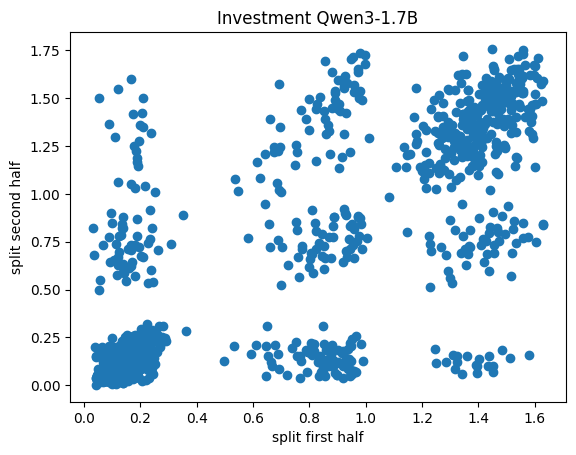

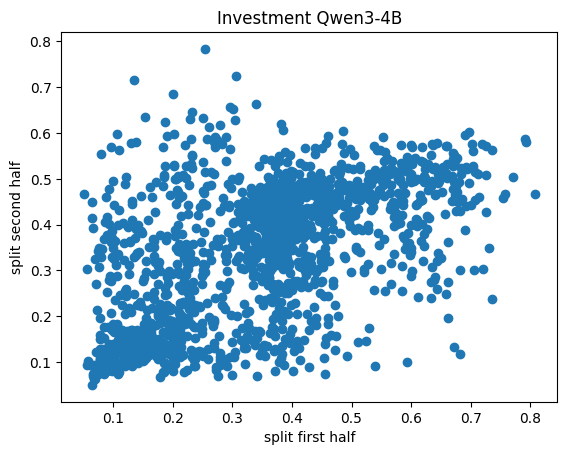

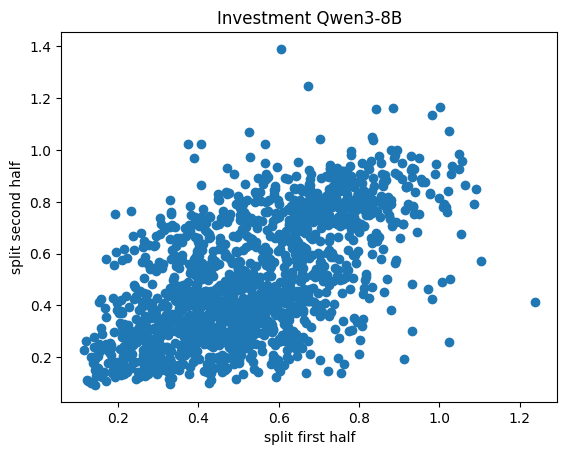

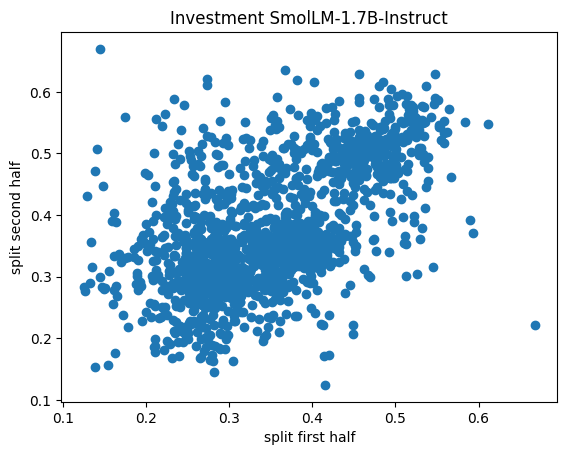

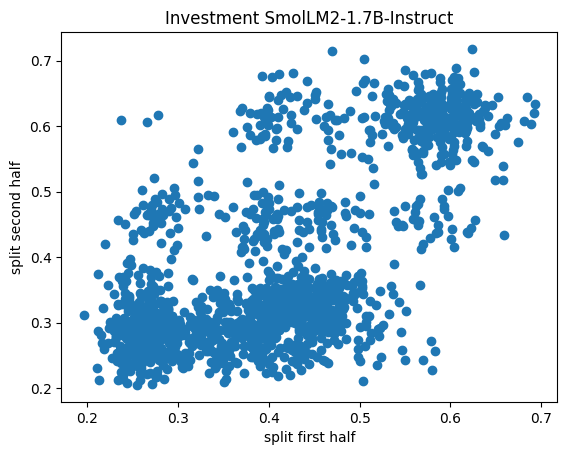

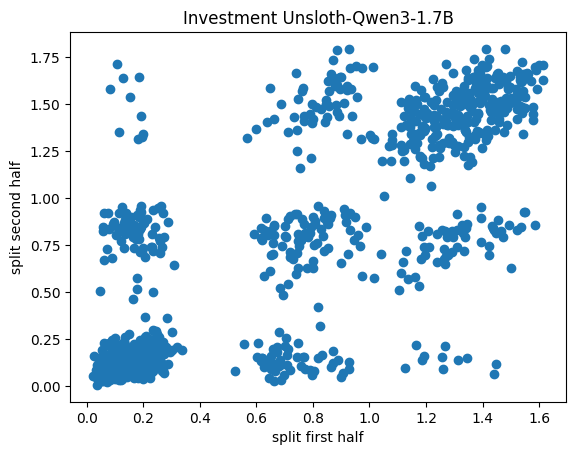

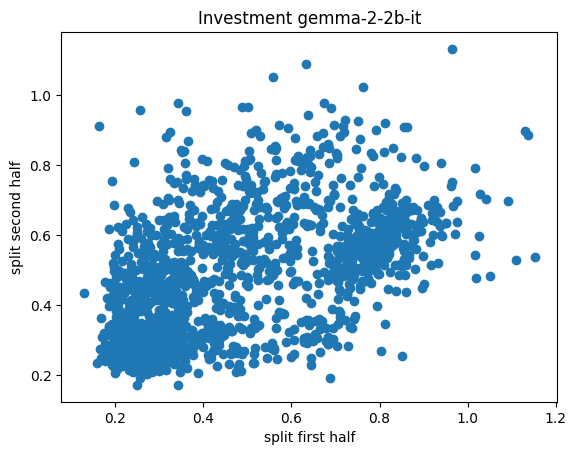

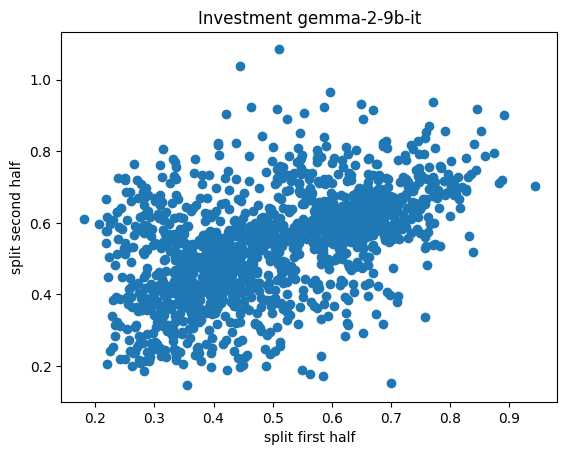

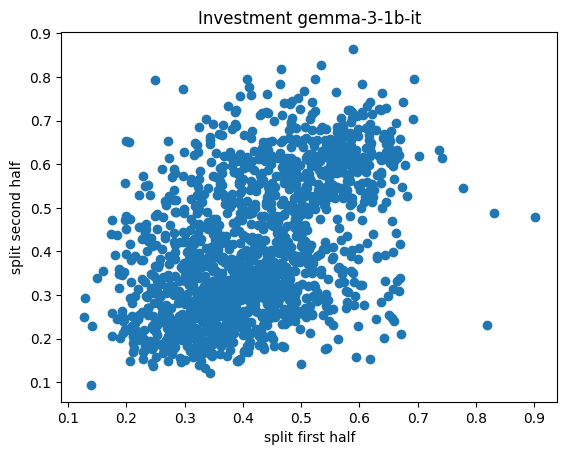

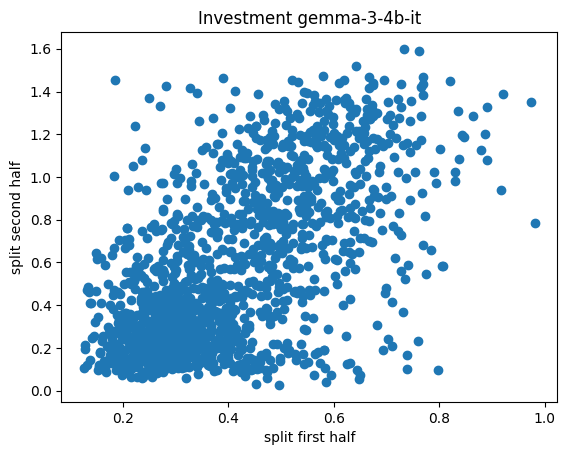

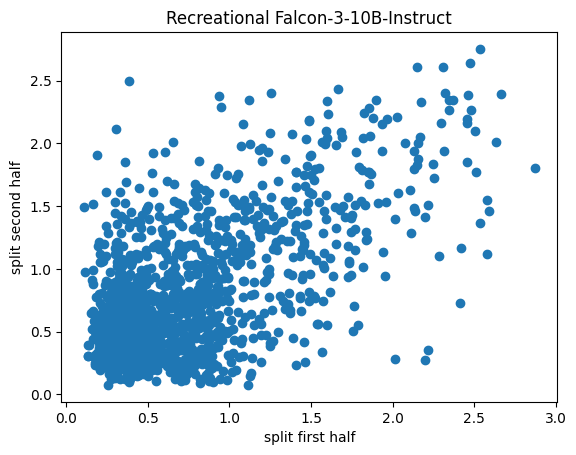

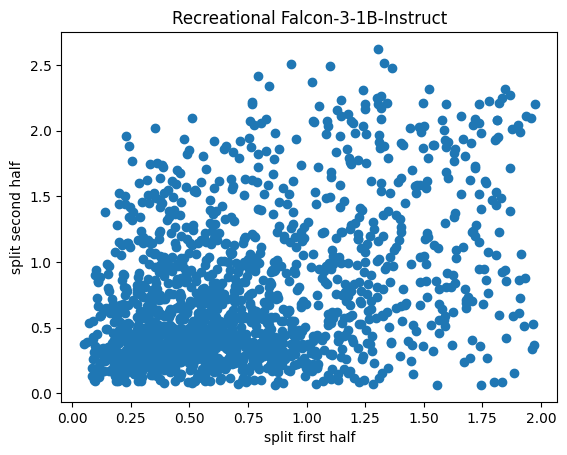

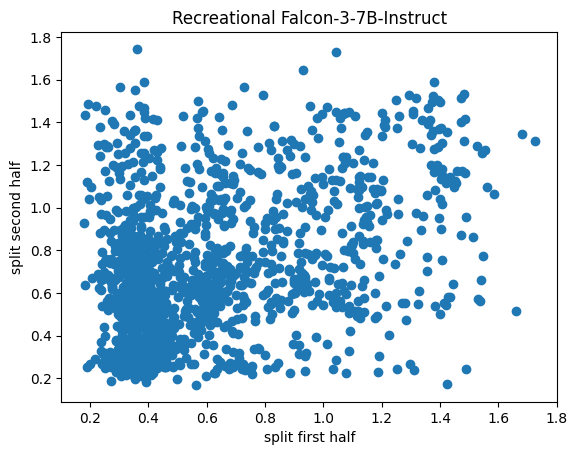

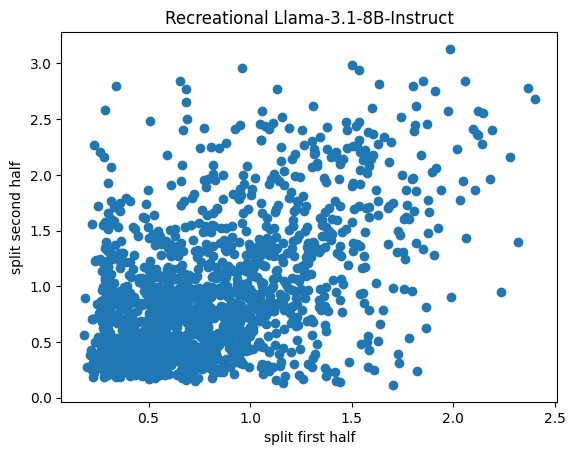

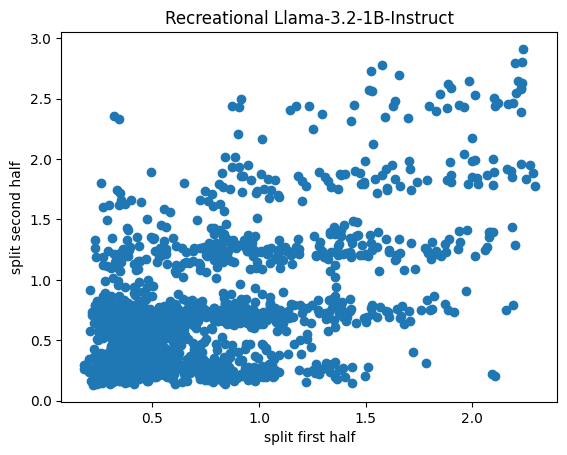

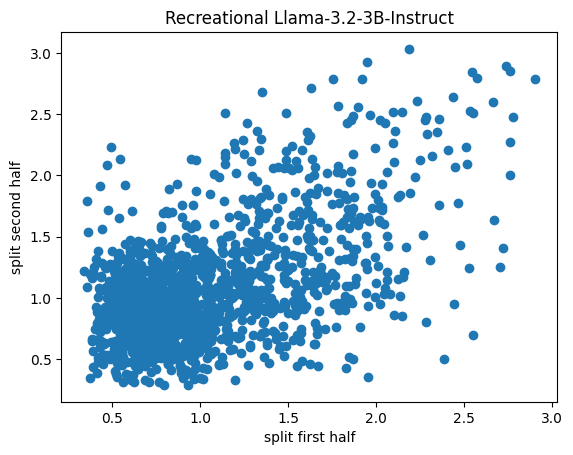

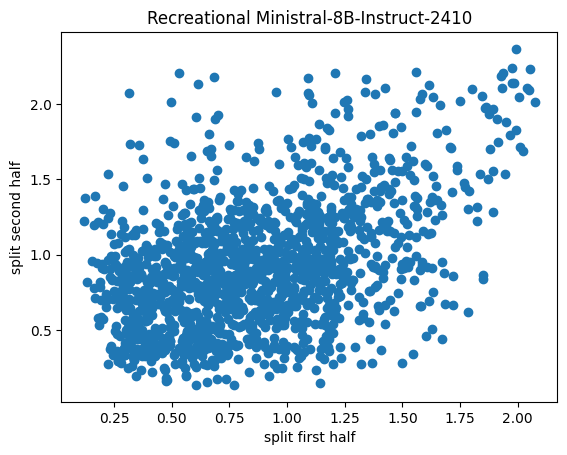

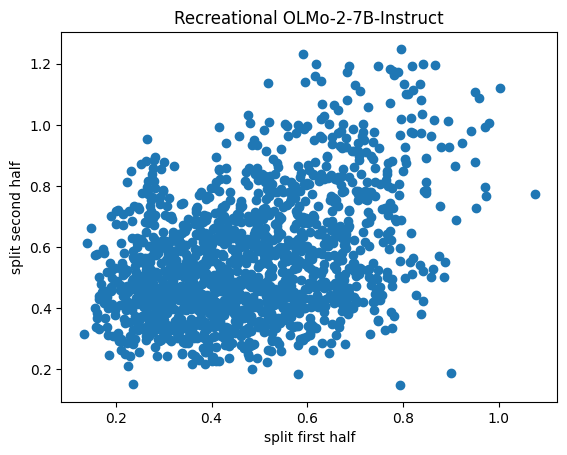

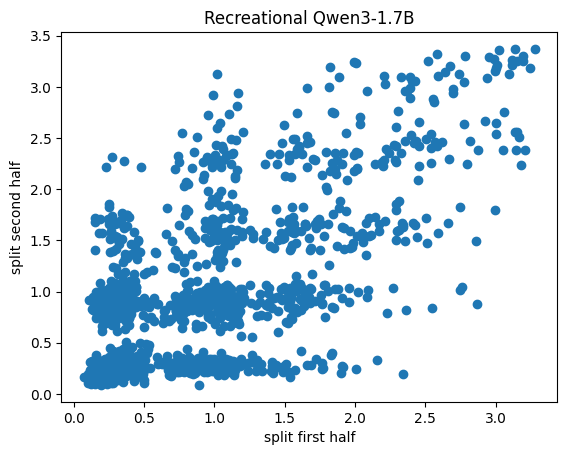

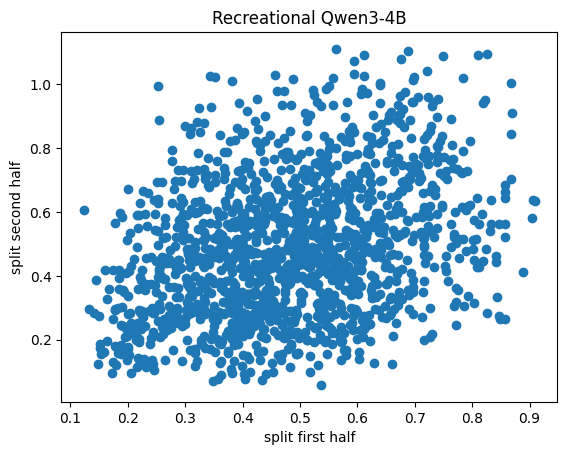

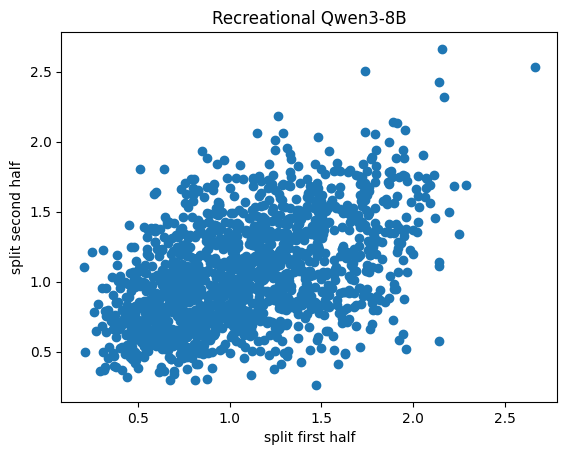

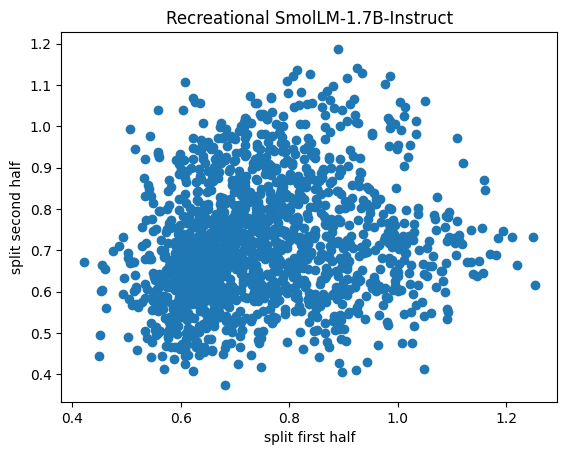

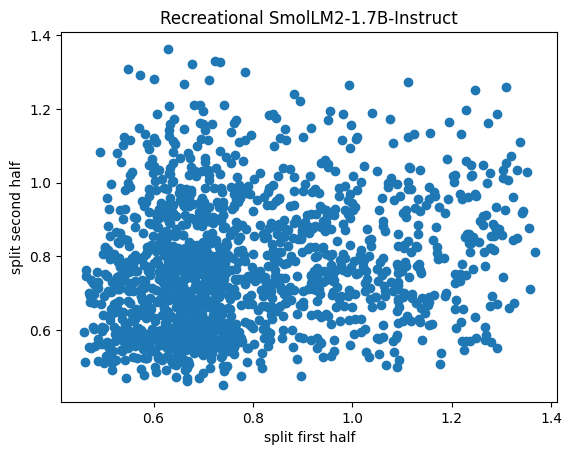

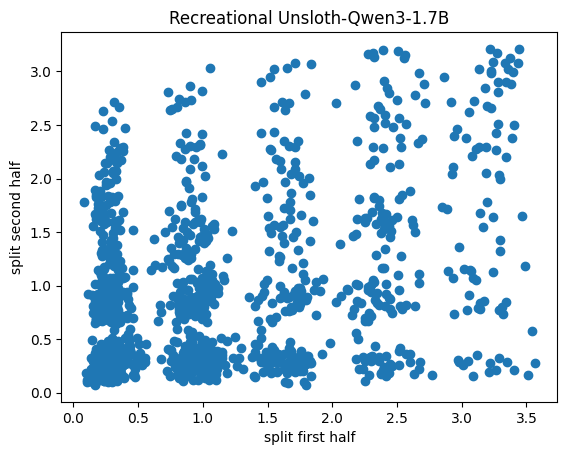

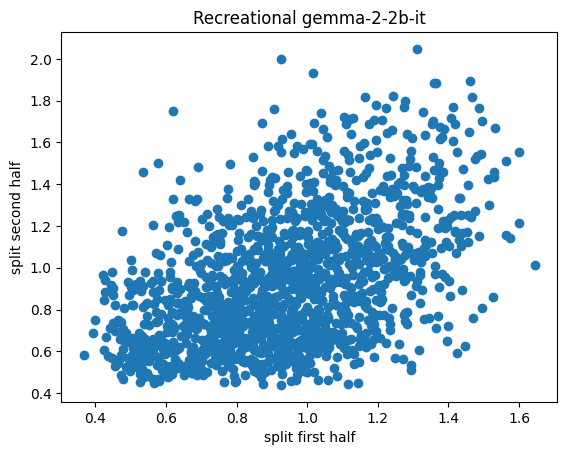

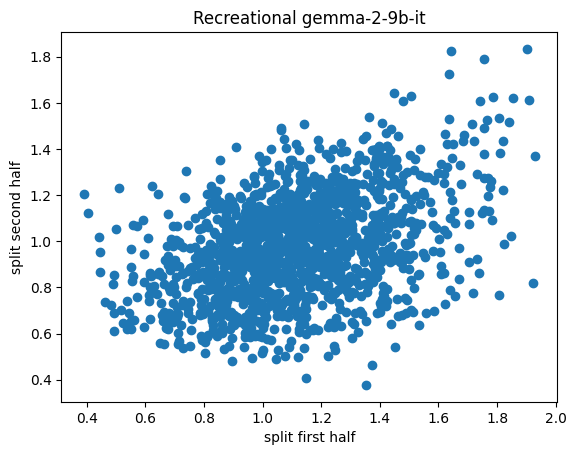

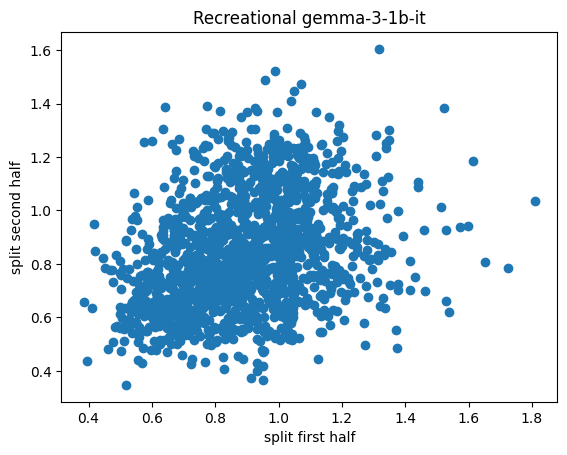

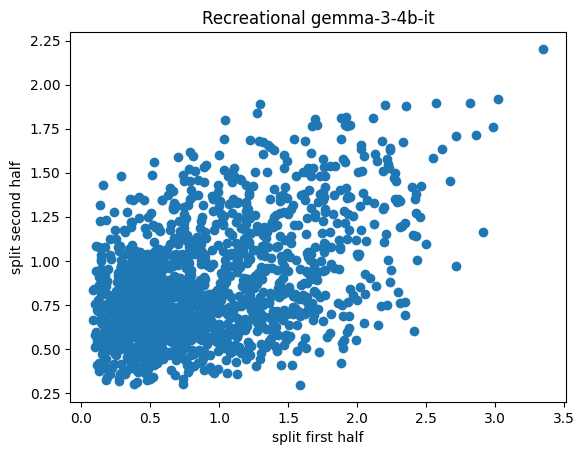

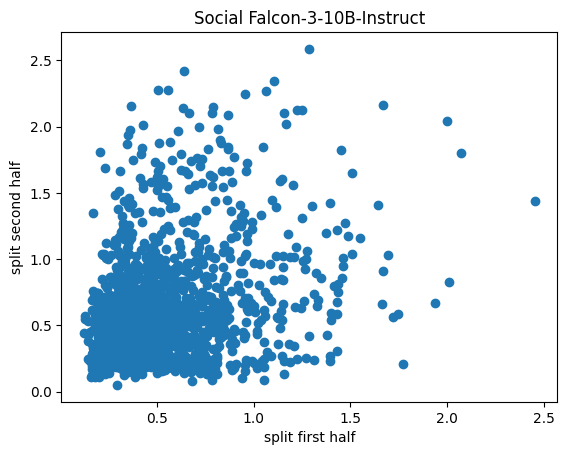

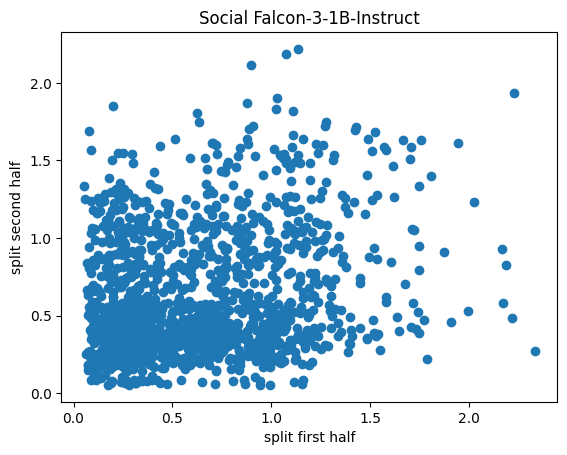

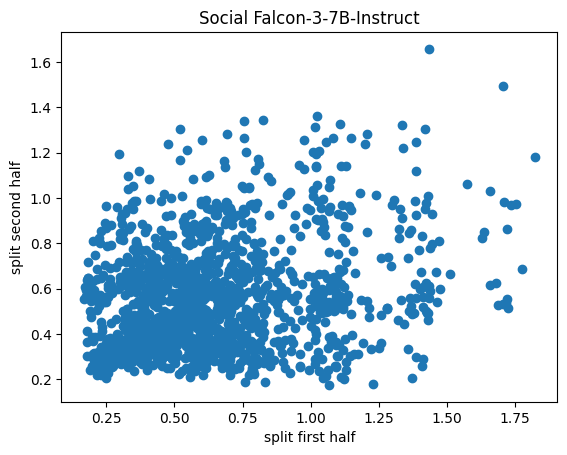

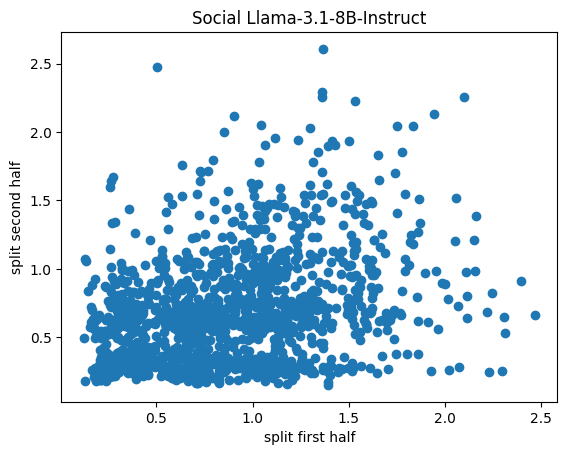

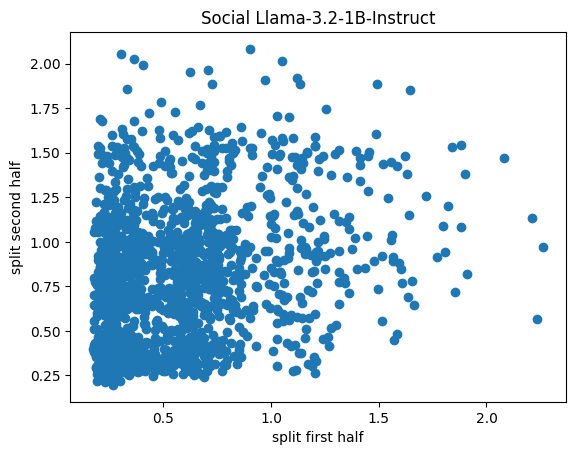

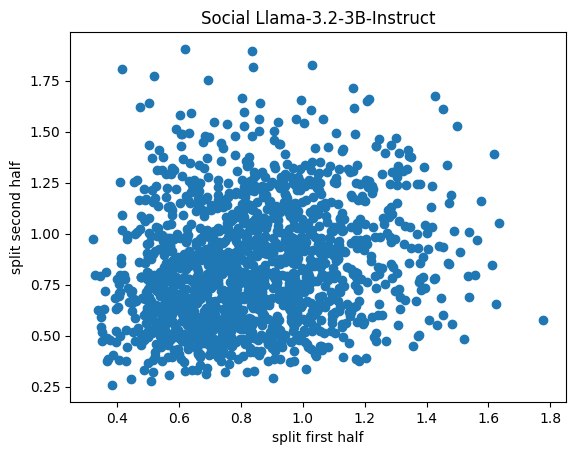

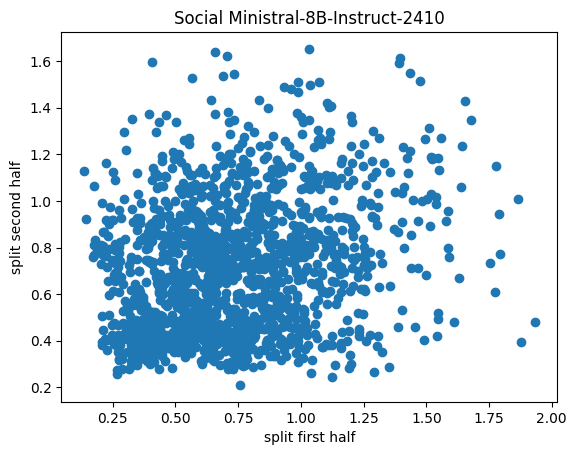

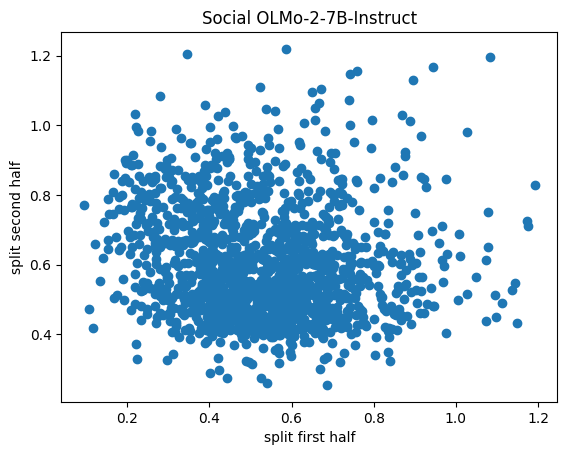

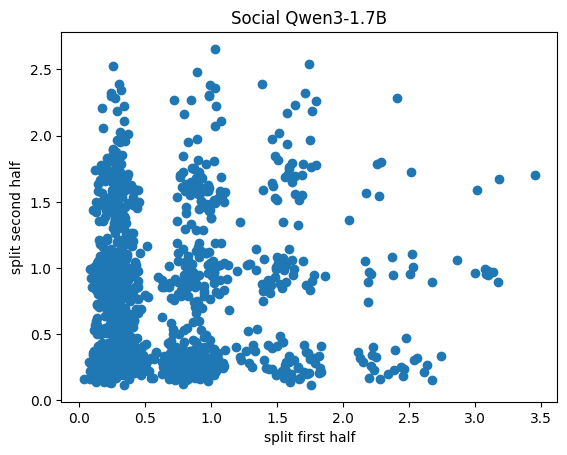

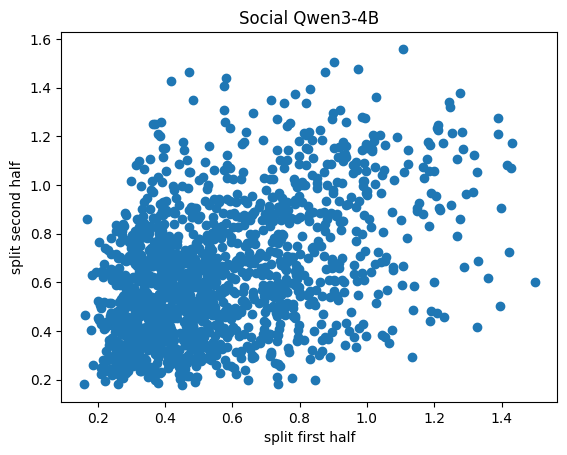

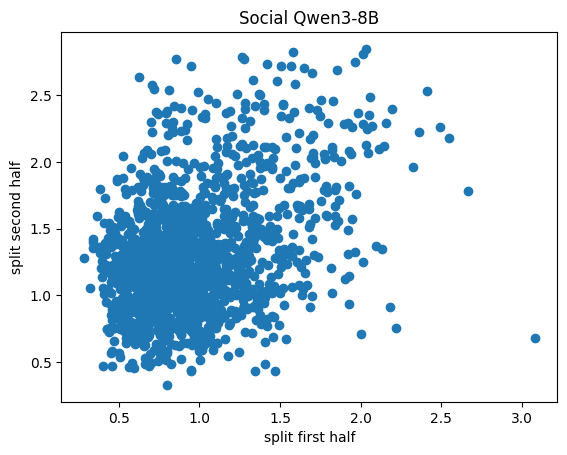

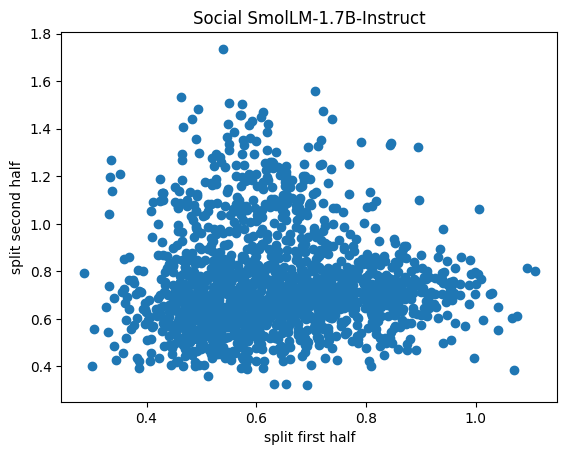

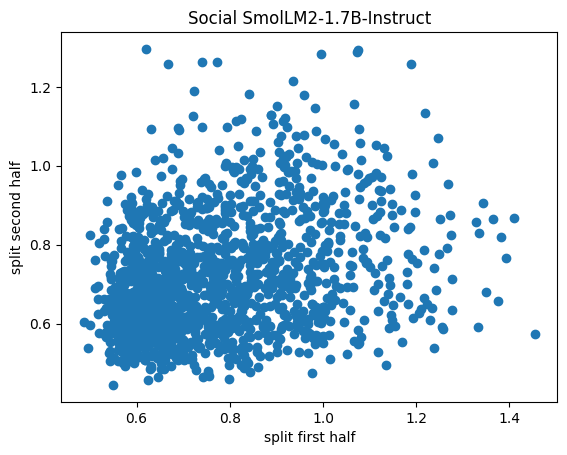

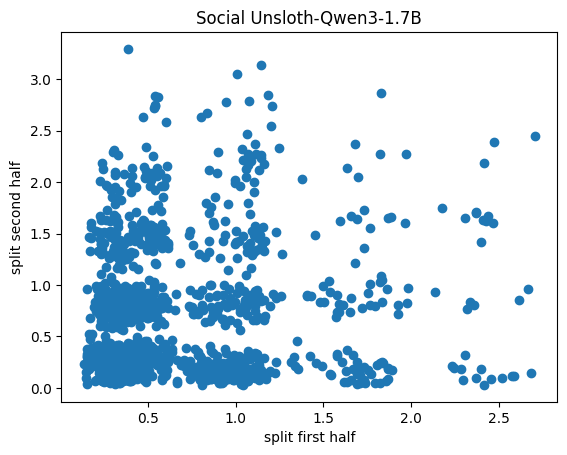

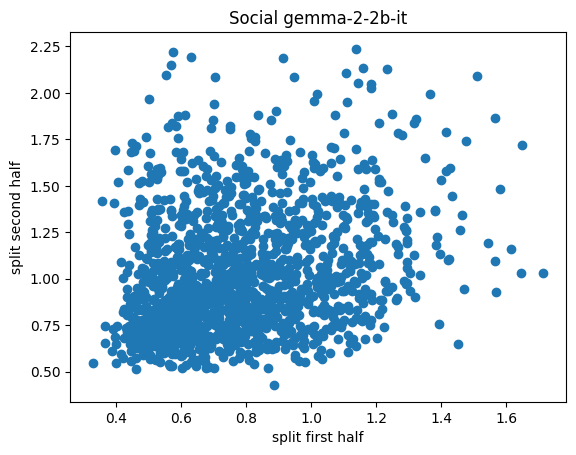

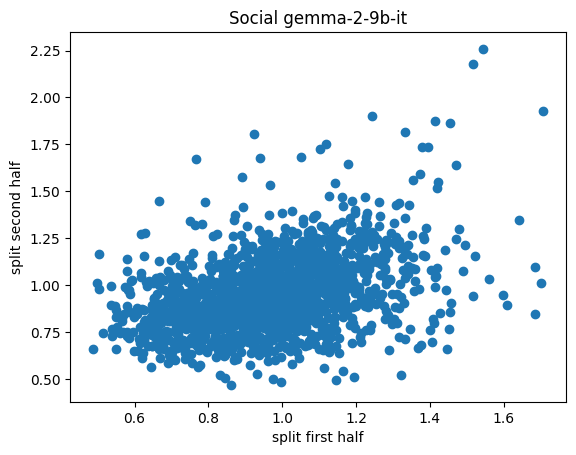

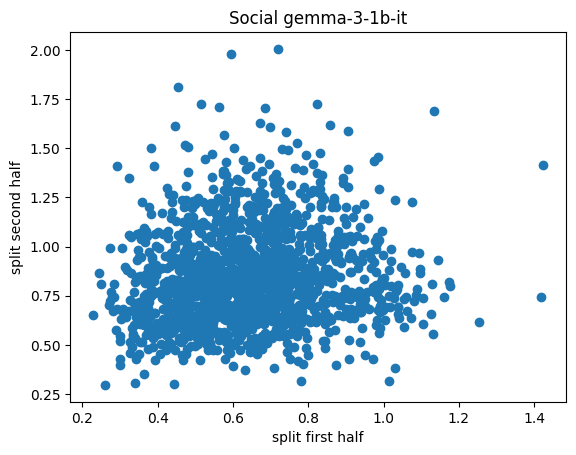

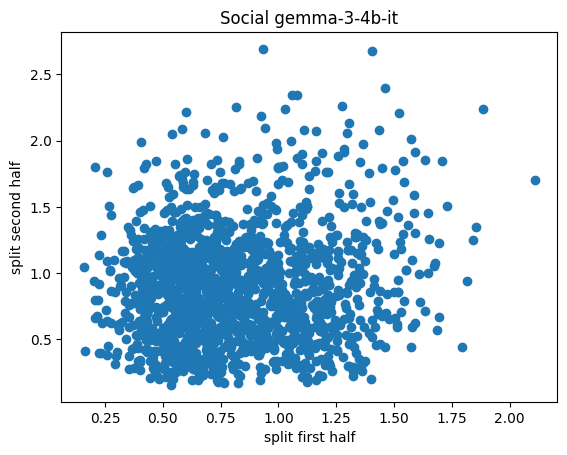

domain                       Ethical  Gambling    Health  Investment  \
model                                                                  
Falcon-3-10B-Instruct       0.784562  0.844326  0.627782    0.673034   
Falcon-3-1B-Instruct        0.812114  0.803450  0.427063    0.847705   
Falcon-3-7B-Instruct        0.836522  0.844139  0.488666    0.845204   
Llama-3.1-8B-Instruct       0.728157  0.803886  0.476464    0.851702   
Llama-3.2-1B-Instruct       0.836051  0.903134  0.543821    0.894486   
Llama-3.2-3B-Instruct       0.821134  0.825971  0.419235    0.850666   
Ministral-8B-Instruct-2410  0.748822  0.748244  0.365031    0.759069   
OLMo-2-7B-Instruct          0.247454  0.319539  0.389984    0.437809   
Qwen3-1.7B                  0.884787  0.938206  0.564542    0.911061   
Qwen3-4B                    0.791554  0.798324  0.499493    0.702759   
Qwen3-8B                    0.804678  0.795702  0.400581    0.765105   
SmolLM-1.7B-Instruct        0.571733  0.073561  0.198729    0.726513   
SmolLM2-1.7B-Instruct       0.756000  0.819207  0.536805    0.765186   
Unsloth-Qwen3-1.7B          0.886913  0.938827  0.539136    0.909144   
gemma-2-2b-it               0.777969  0.721276  0.387024    0.752230   
gemma-2-9b-it               0.820471  0.647524  0.614883    0.655807   
gemma-3-1b-it               0.822369  0.709883  0.575005    0.680483   
gemma-3-4b-it               0.791001  0.871808  0.473949    0.780398   

domain                      Recreational    Social  
model                                               
Falcon-3-10B-Instruct           0.724410  0.536178  
Falcon-3-1B-Instruct            0.630190  0.360049  
Falcon-3-7B-Instruct            0.591084  0.401594  
Llama-3.1-8B-Instruct           0.673706  0.556365  
Llama-3.2-1B-Instruct           0.743732  0.507734  
Llama-3.2-3B-Instruct           0.678303  0.252966  
Ministral-8B-Instruct-2410      0.590845  0.368681  
OLMo-2-7B-Instruct              0.572964  0.082546  
Qwen3-1.7B                      0.750533  0.440047  
Qwen3-4B                        0.457452  0.651156  
Qwen3-8B                        0.581013  0.563008  
SmolLM-1.7B-Instruct            0.333525  0.281057  
SmolLM2-1.7B-Instruct           0.541404  0.435523  
Unsloth-Qwen3-1.7B              0.748272  0.378682  
gemma-2-2b-it                   0.484259  0.521986  
gemma-2-9b-it                   0.588881  0.537798  
gemma-3-1b-it                   0.451678  0.327924  
gemma-3-4b-it                   0.615609  0.259517

In [11]:
# ---- split-half reliability -----
# Split-half reliability in this context measures whether LLM assigns similar relative probabilities to the human’s responses across subsets of items.

def split_half_reliability(df_items, n_splits=10, vis = False, domain = None, model = None):
    """Compute average split-half reliability (Spearman–Brown corrected)."""
    k = df_items.shape[1]
    colnames = df_items.columns
    results = []
    
    for i in range(n_splits):
        shuffled = list(colnames)
        random.shuffle(shuffled)
        half1, half2 = shuffled[:k//2], shuffled[k//2:]
        
        s1 = df_items[half1].sum(axis=1)
        s2 = df_items[half2].sum(axis=1)

        if vis == True and i == 1:
            plt.scatter(s1, s2)
            plt.xlabel("split first half")
            plt.ylabel("split second half")
            plt.title(f"{domain} {model}")
            plt.show()

        r, _ = pearsonr(s1, s2)
        if np.isfinite(r): 
            r_sb = (2 * r) / (1 + r)
            results.append(r_sb)
        
    if results:
        return np.mean(results), np.std(results)
    else:
        return np.nan, np.nan  # No valid splits
    
split_results = []

# loop through domains
for domain, domain_data in merged_dospert_data.groupby("domain"):
    # loop through models
    for model, model_data in domain_data.groupby("model"):

        # pivot wide format for split half rel
        df_wide_domains = model_data.pivot_table(
            index="participant",
            columns="item",
            values="prob_predicted"
        )
        #print(df_wide_domains)
        
        # calculate split-half rel
        rel, sd = split_half_reliability(df_wide_domains, vis = True, domain = domain, model = model)
    
        # store results
        split_results.append({
            "domain": domain,
            "model": model,
            "split_rel": rel,
            "sd_split_rel": sd
        })

# convert to DataFrame
split_rel_df = pd.DataFrame(split_results)
split_rel_df

# transfer to wide format
split_rel_wide = split_rel_df.pivot_table(
    index=['model'],
    columns='domain',
    values='split_rel'
).reset_index()
split_rel_wide.set_index("model", inplace=True)
# show
split_rel_wide


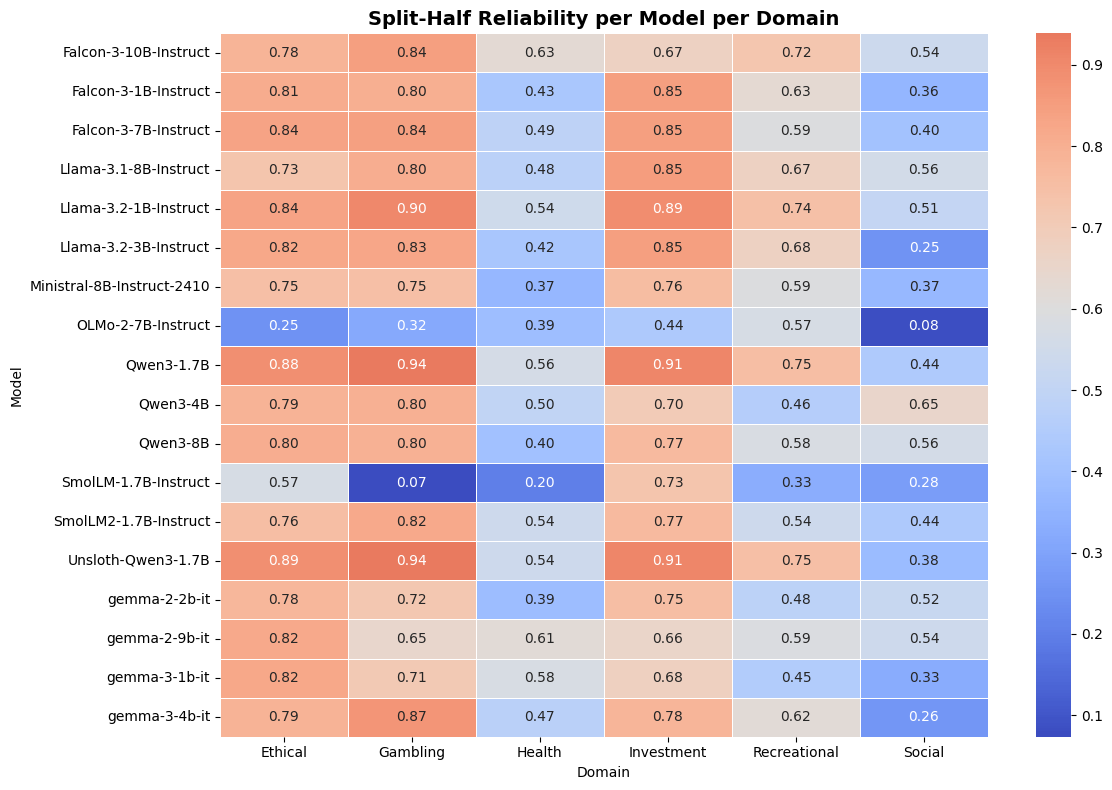

In [12]:
# Visualize Split-half reliability for each model and category
plt.figure(figsize=(12, 8))
sns.heatmap(split_rel_wide, annot=True, cmap="coolwarm", center=0.6, fmt=".2f", linewidths=.5)
plt.title("Split-Half Reliability per Model per Domain", fontsize=14, weight="bold")
plt.xlabel("Domain")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

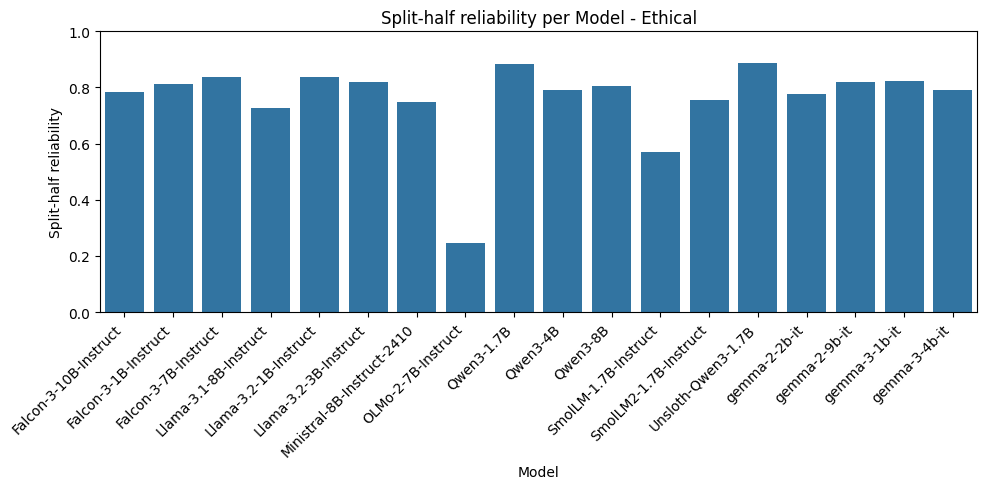

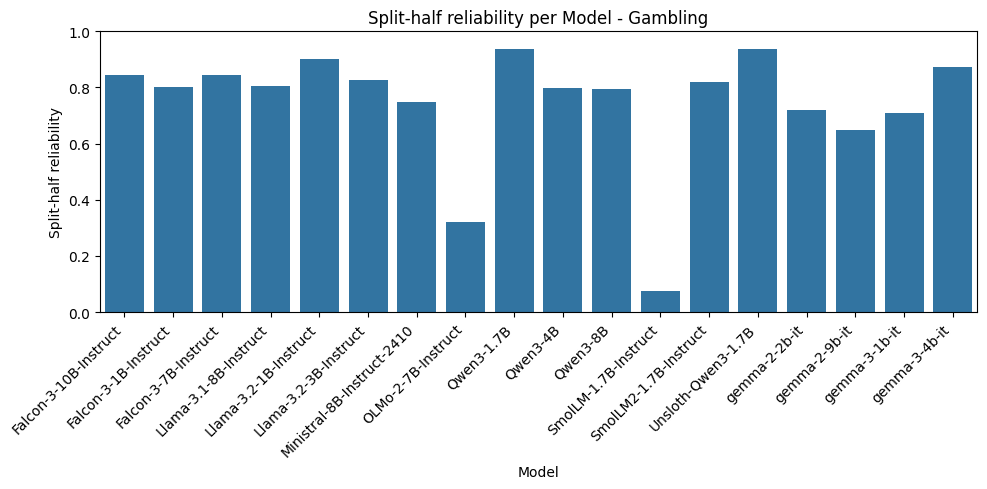

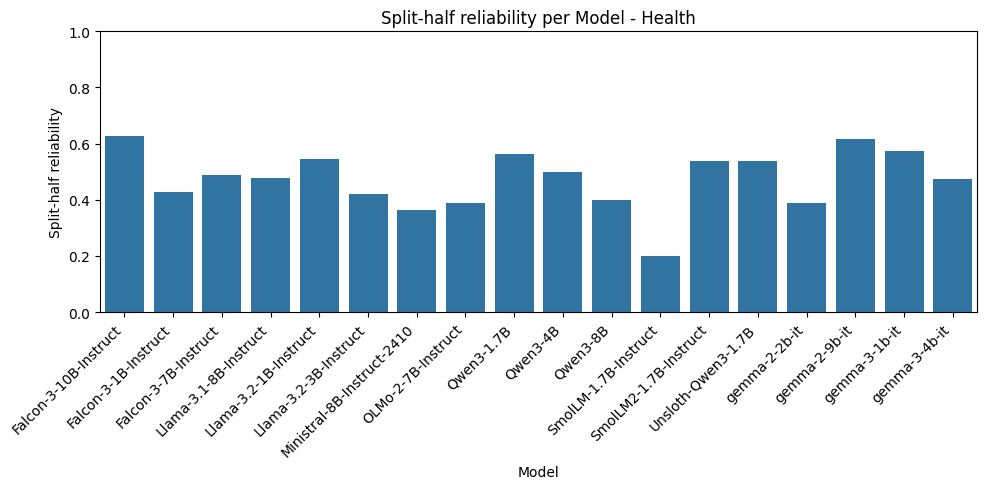

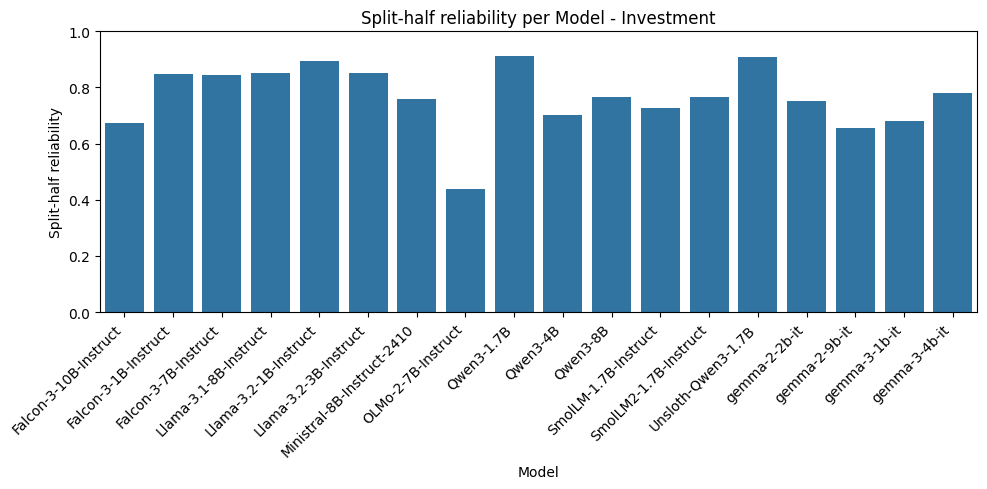

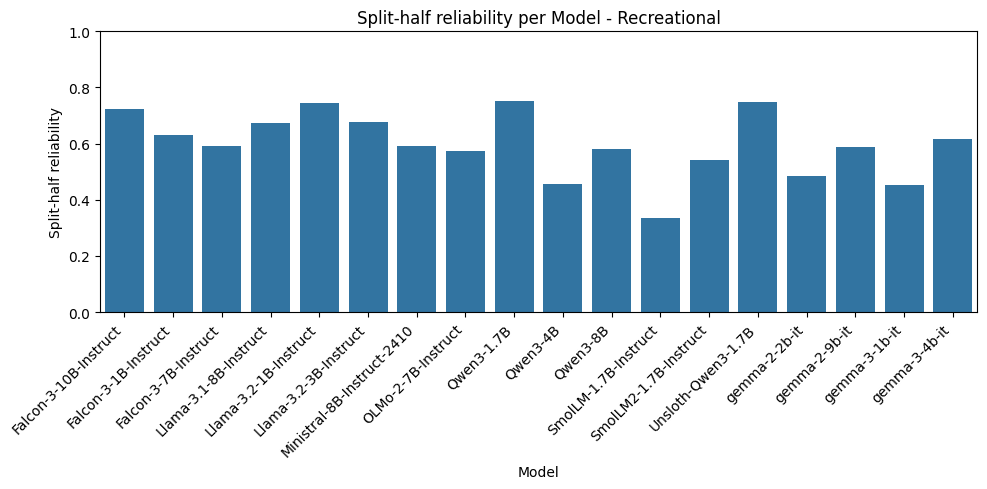

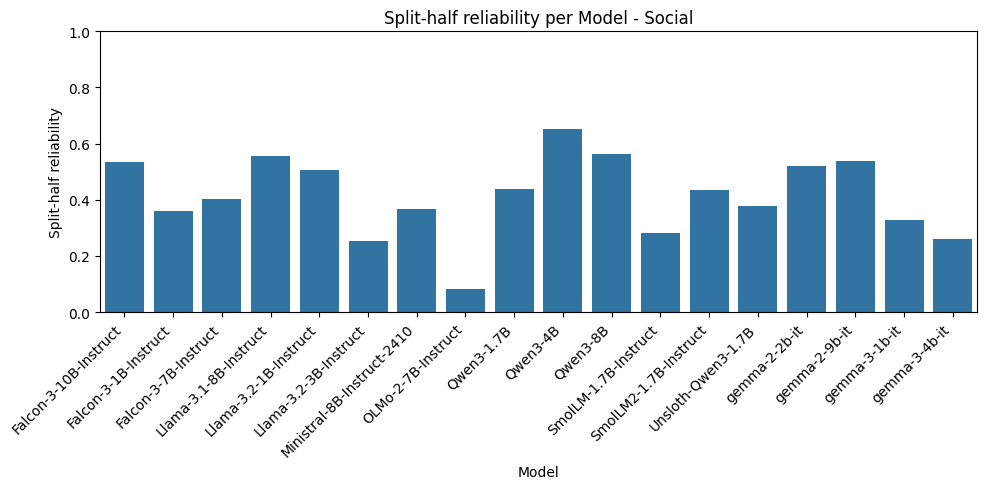

In [13]:
# loop through each domain and plot reliability per model
domains = split_rel_df['domain'].unique()

for domain in domains:
    df_plot = split_rel_df[split_rel_df['domain'] == domain]
    
    plt.figure(figsize=(10,5))
    sns.barplot(data=df_plot, x='model', y='split_rel')
    
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.title(f"Split-half reliability per Model - {domain}")
    plt.ylabel("Split-half reliability")
    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()


## Analyses on full scale - Probably non-sensical

In [14]:
# merged_dospert_data: long format with columns ['participant', 'item', 'model', 'prob_predicted']

df_wide = merged_dospert_data.pivot_table(
    index=['model', 'participant'],
    columns='item',
    values='prob_predicted'
).reset_index()

#df_wide: columns = wide format data with columns ['model', 'participant', item1, 2, ..., 40]

# ---- Cronbach's alpha full scale  ----
alphas = {}
alpha_ci = {}

for m, sub in df_wide.groupby("model"):
    scores = sub.drop(columns=["model", "participant"])
    alpha, ci = pg.cronbach_alpha(data=scores)

    alphas[m] = alpha
    alpha_ci[m] = ci

alpha_df = pd.DataFrame({
    "model": list(alphas.keys()),
    "alpha": list(alphas.values()),
    "alpha_CI": list(alpha_ci.values())
})

# ---- split-half on full scale ----
split_results = {}

for m, sub in df_wide.groupby("model"):
    items = sub.drop(columns=["model", "participant"])
    mean_rsb, sd_rsb = split_half_reliability(items)
    split_results[m] = (mean_rsb, sd_rsb)

split_df = pd.DataFrame([
    {"model": m, "split_half_mean": mean, "split_half_sd": sd}
    for m, (mean, sd) in split_results.items()
])

results_df = alpha_df.merge(split_df, on="model")
results_df

model     alpha        alpha_CI  split_half_mean  \
0        Falcon-3-10B-Instruct  0.901327  [0.894, 0.908]         0.909361   
1         Falcon-3-1B-Instruct  0.861366  [0.851, 0.871]         0.874699   
2         Falcon-3-7B-Instruct  0.875265  [0.866, 0.884]         0.888766   
3        Llama-3.1-8B-Instruct  0.871924  [0.862, 0.881]         0.879807   
4        Llama-3.2-1B-Instruct  0.908301  [0.902, 0.915]         0.912008   
5        Llama-3.2-3B-Instruct  0.863215  [0.853, 0.873]         0.867618   
6   Ministral-8B-Instruct-2410  0.823177   [0.81, 0.836]         0.820758   
7           OLMo-2-7B-Instruct  0.612654   [0.584, 0.64]         0.635278   
8                   Qwen3-1.7B  0.922970  [0.917, 0.928]         0.937849   
9                     Qwen3-4B  0.804534   [0.79, 0.818]         0.811734   
10                    Qwen3-8B  0.823367   [0.81, 0.836]         0.841166   
11        SmolLM-1.7B-Instruct  0.632991  [0.606, 0.659]         0.605117   
12       SmolLM2-1.7B-Instruct  0.857661  [0.847, 0.868]         0.869549   
13          Unsloth-Qwen3-1.7B  0.922970  [0.917, 0.928]         0.927305   
14               gemma-2-2b-it  0.759577  [0.742, 0.777]         0.795473   
15               gemma-2-9b-it  0.856819  [0.846, 0.867]         0.866094   
16               gemma-3-1b-it  0.857063  [0.847, 0.867]         0.870089   
17               gemma-3-4b-it  0.854224  [0.843, 0.865]         0.857041   

    split_half_sd  
0        0.014653  
1        0.022265  
2        0.010354  
3        0.017630  
4        0.011598  
5        0.016958  
6        0.020007  
7        0.040776  
8        0.010209  
9        0.047233  
10       0.032441  
11       0.109791  
12       0.019508  
13       0.020909  
14       0.031358  
15       0.012906  
16       0.010703  
17       0.032085

## Analyses on Human Data only

In [15]:
# ----- measure reliability of DOSPERT responses in humans ------------

# extract human answers
human_data = merged_dospert_data[merged_dospert_data["model"] == "Falcon-3-10B-Instruct"]

# Identify flipped rows again
flip_mask = human_data['flipped'] == 'yes'

# Flip them back
human_data.loc[flip_mask, "human_number"] = 6 - human_data.loc[flip_mask, "human_number"]

# to wide format for analyses
df_wide_human = human_data.pivot_table(
    index=['participant'],
    columns='item',
    values='human_number'
).reset_index()


# ---- Cronbach's alpha ----
df_wide_human_without_participant_id = df_wide_human.drop(columns=["participant"])
print(f"Cronbach's Alpha for human answers: {pg.cronbach_alpha(df_wide_human_without_participant_id)[0]}, Confidence Interval: {pg.cronbach_alpha(df_wide_human_without_participant_id)[1]}")


Cronbach's Alpha for human answers: 0.8810453592185342, Confidence Interval: [0.872 0.889]


In [16]:
# --- Calculate human cronbachs alpha divided by domain ---
# dictionary to store results
alphas = {}

# loop through domains
for domain, domain_data in human_data.groupby("domain"):
    # pivot wide format for this domain
    df_wide = domain_data.pivot_table(
        index="participant",
        columns="item",
        values="human_number"
    )
    # drop participant id if present
    df_wide = df_wide.dropna(axis=0)  # ensure no missing rows
    
    # calculate Cronbach's alpha
    alpha, ci = pg.cronbach_alpha(df_wide)
    
    alphas[domain] = {"alpha": alpha, "ci": ci}

alphas


{'Ethical': {'alpha': 0.785718737394081, 'ci': array([0.769, 0.802])},
 'Gambling': {'alpha': 0.7716849767368072, 'ci': array([0.752, 0.79 ])},
 'Health': {'alpha': 0.6852888367275239, 'ci': array([0.661, 0.709])},
 'Investment': {'alpha': 0.8213228655960135, 'ci': array([0.806, 0.836])},
 'Recreational': {'alpha': 0.8096413201624088, 'ci': array([0.795, 0.824])},
 'Social': {'alpha': 0.5784425933661972, 'ci': array([0.545, 0.61 ])}}

In [17]:
# ---- overall DOSPERT score per participant (all items) ----
# overall = (
#     human_data
#     .groupby("participant")["human_number"]
#     .mean()
#     .rename("DOSPERT")
# )

# ---- mean per domain ----
domains = (
    human_data
    .groupby(["participant", "domain"])["human_number"]
    .mean()
    .unstack()   # wide format: one column per domain
)

# rename domains to short labels
scores = domains.rename(columns={
    "Investment": "Dinv",
    "Gambling": "Dgam",
    "Health": "Dhea",
    "Recreational": "Drec",
    "Social": "Dsoc", 
    "Ethical": "Deth"
})

# ---- merge overall + domains into one dataframe ----
#scores = pd.concat([overall, domains], axis=1).reset_index()

scores.head(20)


domain        Deth  Dgam   Dhea  Dinv   Drec   Dsoc
participant                                        
64000401     2.250  1.00  3.500  1.00  3.375  3.625
64004701     2.250  1.00  3.625  1.75  2.875  2.875
64006401     3.125  1.00  3.875  1.00  2.500  3.250
64006901     1.375  1.25  2.875  2.75  2.500  3.500
64007901     1.500  1.00  2.500  3.00  2.875  3.125
64008701     1.250  1.75  1.625  2.25  2.000  3.125
64011501     2.875  1.25  3.750  1.00  2.875  4.125
64015601     1.250  1.00  1.750  1.75  1.750  3.000
64016901     2.750  2.50  2.500  3.50  2.875  3.250
64018301     1.750  1.00  1.625  2.00  1.625  3.000
64020401     1.500  1.00  2.750  1.00  2.500  2.375
64020501     2.625  1.00  2.250  1.00  3.250  4.125
64021901     2.250  1.00  1.750  1.00  2.625  3.500
64022901     2.000  1.00  2.125  1.00  3.500  3.125
64025601     3.375  1.25  3.000  1.75  2.625  2.875
64026901     1.375  1.00  2.375  1.50  1.000  4.000
64027801     1.750  1.00  2.500  1.00  3.625  2.750
64029901     1.500  1.00  2.000  1.00  1.500  3.000
64031301     1.250  1.00  1.125  1.75  1.125  3.500
64034901     2.250  1.00  3.500  2.00  4.000  4.750

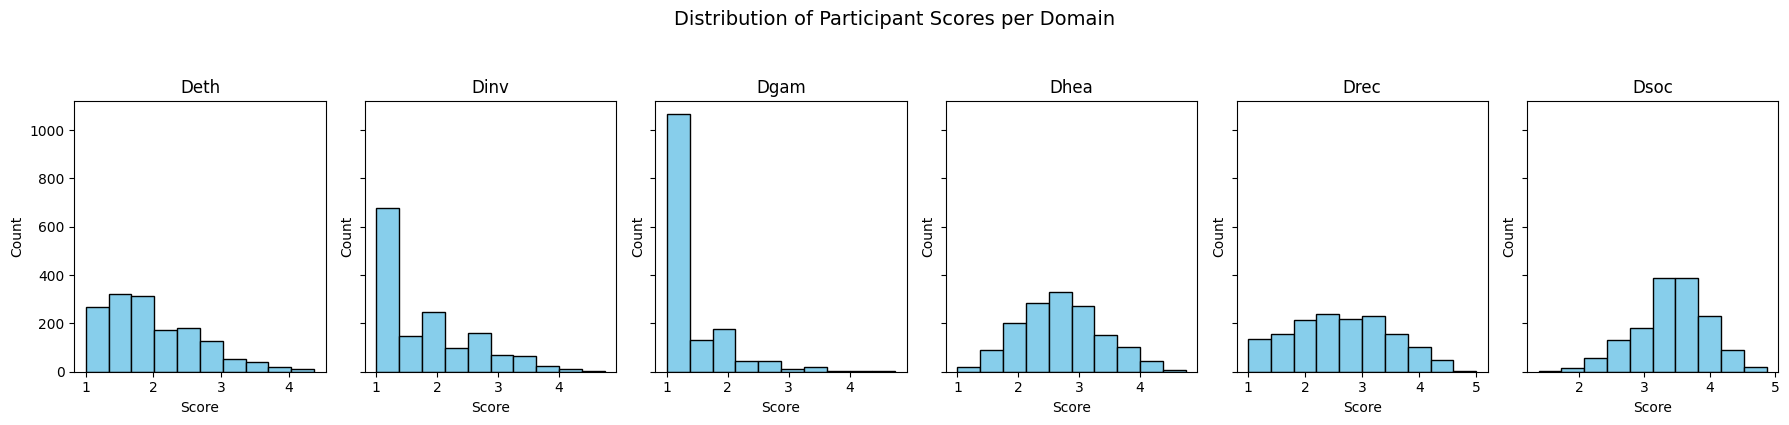

In [18]:
# compute group mean per domain
domains = ["Deth", "Dinv", "Dgam", "Dhea", "Drec", "Dsoc"]

fig, axes = plt.subplots(1, len(domains), figsize=(18,4), sharey=True)

for ax, dom in zip(axes, domains):
    ax.hist(scores[dom], bins=10, color="skyblue", edgecolor="black")
    ax.set_title(dom)
    ax.set_xlabel("Score")
    ax.set_ylabel("Count")

plt.suptitle("Distribution of Participant Scores per Domain", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()
